In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [33]:
# Step 1: Load dataset and set timestamp to Irish timezone
file_path = "../mydata/data_lstm/complete_dataset.csv"
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
df.head()

,Unnamed: 0,Timestamp,rain,temp,rhum,msl,wdsp,vis,clht,clamt,...,car_r1,hgv_r1,car_r2,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station
0,0,2023-01-01 00:00:00+00:00,0.0,5.2,95,996.5,8,15000,200.0,6,...,143.0,8.0,458.0,9.0,384.0,27.0,176,7,30.578458,LG
1,1,2023-01-01 01:00:00+00:00,0.0,4.7,93,996.9,6,20000,40.0,5,...,206.0,13.0,478.0,13.0,415.0,26.0,214,13,30.578458,LG
2,2,2023-01-01 02:00:00+00:00,0.1,5.4,94,996.9,5,20000,37.0,7,...,170.0,10.0,371.0,11.0,270.0,20.0,114,14,30.578458,LG
3,3,2023-01-01 03:00:00+00:00,0.4,5.6,94,997.4,7,20000,26.0,7,...,128.0,9.0,304.0,9.0,217.0,16.0,84,3,30.578458,LG
4,4,2023-01-01 04:00:00+00:00,0.0,4.7,97,997.1,3,20000,50.0,7,...,48.0,5.0,138.0,7.0,105.0,4.0,45,10,30.578458,LG


In [34]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert('Europe/Dublin')
df['hour']=df['Timestamp'].dt.hour
df['date']=df['Timestamp'].dt.date
df.set_index('Timestamp', inplace=True)
df.head()

,Unnamed: 0,rain,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,...,car_r2,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,0,0.0,5.2,95,996.5,8,15000,200.0,6,21.58,...,458.0,9.0,384.0,27.0,176,7,30.578458,LG,0,2023-01-01
2023-01-01 01:00:00+00:00,1,0.0,4.7,93,996.9,6,20000,40.0,5,49.08,...,478.0,13.0,415.0,26.0,214,13,30.578458,LG,1,2023-01-01
2023-01-01 02:00:00+00:00,2,0.1,5.4,94,996.9,5,20000,37.0,7,51.23,...,371.0,11.0,270.0,20.0,114,14,30.578458,LG,2,2023-01-01
2023-01-01 03:00:00+00:00,3,0.4,5.6,94,997.4,7,20000,26.0,7,51.03,...,304.0,9.0,217.0,16.0,84,3,30.578458,LG,3,2023-01-01
2023-01-01 04:00:00+00:00,4,0.0,4.7,97,997.1,3,20000,50.0,7,50.53,...,138.0,7.0,105.0,4.0,45,10,30.578458,LG,4,2023-01-01


In [35]:
df

,Unnamed: 0,rain,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,...,car_r2,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,0,0.0,5.2,95,996.5,8,15000,200.0,6,21.580000,...,458.0,9.0,384.0,27.0,176,7,30.578458,LG,0,2023-01-01
2023-01-01 01:00:00+00:00,1,0.0,4.7,93,996.9,6,20000,40.0,5,49.080000,...,478.0,13.0,415.0,26.0,214,13,30.578458,LG,1,2023-01-01
2023-01-01 02:00:00+00:00,2,0.1,5.4,94,996.9,5,20000,37.0,7,51.230000,...,371.0,11.0,270.0,20.0,114,14,30.578458,LG,2,2023-01-01
2023-01-01 03:00:00+00:00,3,0.4,5.6,94,997.4,7,20000,26.0,7,51.030000,...,304.0,9.0,217.0,16.0,84,3,30.578458,LG,3,2023-01-01
2023-01-01 04:00:00+00:00,4,0.0,4.7,97,997.1,3,20000,50.0,7,50.530000,...,138.0,7.0,105.0,4.0,45,10,30.578458,LG,4,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 19:00:00+01:00,51943,0.0,14.4,71,1018.9,10,40000,70.0,7,13.420667,...,1329.0,42.0,1335.0,111.0,909,79,8.099116,GP,19,2024-06-30
2024-06-30 20:00:00+01:00,51944,0.0,13.2,80,1019.4,10,35000,60.0,7,15.303667,...,1016.0,18.0,986.0,74.0,769,51,8.099116,GP,20,2024-06-30
2024-06-30 21:00:00+01:00,51945,0.2,12.2,89,1019.5,8,35000,60.0,7,12.910333,...,684.0,13.0,654.0,43.0,440,31,8.099116,GP,21,2024-06-30


In [36]:
# Step 2: Drop 'Unnamed: 0' and 'rain' if present
df.drop(columns=[col for col in ['Unnamed: 0', 'rain'] if col in df.columns], inplace=True)
df.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,weekday_iso,...,car_r2,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,5.2,95,996.5,8,15000,200.0,6,21.58,0,7,...,458.0,9.0,384.0,27.0,176,7,30.578458,LG,0,2023-01-01
2023-01-01 01:00:00+00:00,4.7,93,996.9,6,20000,40.0,5,49.08,0,7,...,478.0,13.0,415.0,26.0,214,13,30.578458,LG,1,2023-01-01
2023-01-01 02:00:00+00:00,5.4,94,996.9,5,20000,37.0,7,51.23,0,7,...,371.0,11.0,270.0,20.0,114,14,30.578458,LG,2,2023-01-01
2023-01-01 03:00:00+00:00,5.6,94,997.4,7,20000,26.0,7,51.03,0,7,...,304.0,9.0,217.0,16.0,84,3,30.578458,LG,3,2023-01-01
2023-01-01 04:00:00+00:00,4.7,97,997.1,3,20000,50.0,7,50.53,0,7,...,138.0,7.0,105.0,4.0,45,10,30.578458,LG,4,2023-01-01


In [37]:
spd_23=df[(df['date']>=pd.to_datetime('2023-03-16').date()) & (df['date']<=pd.to_datetime('2023-03-18').date())]
spd_24=df[(df['date']>=pd.to_datetime('2024-03-16').date()) & (df['date']<=pd.to_datetime('2024-03-18').date())]
cfd=df[(df['date']>=pd.to_datetime('2023-09-22').date()) & (df['date']<=pd.to_datetime('2023-09-24').date())]
osd1=df[(df['date']>=pd.to_datetime('2024-05-18').date()) & (df['date']<=pd.to_datetime('2024-05-20').date())]


df=df[~((df['date']>=pd.to_datetime('2023-03-16').date()) & (df['date']<=pd.to_datetime('2023-03-18').date())) &
      ~((df['date']>=pd.to_datetime('2024-03-16').date()) & (df['date']<=pd.to_datetime('2024-03-18').date())) &
      ~((df['date']>=pd.to_datetime('2023-09-22').date()) & (df['date']<=pd.to_datetime('2023-09-24').date())) &
      ~((df['date']>=pd.to_datetime('2024-05-18').date()) & (df['date']<=pd.to_datetime('2024-05-20').date())) &
      ~((df['date']>=pd.to_datetime('2024-06-15').date()) & (df['date']<=pd.to_datetime('2024-06-17').date()))
      ]

# df=df[~((df['date']>=pd.to_datetime('2024-03-16').date()) & (df['date']<=pd.to_datetime('2024-03-18').date())) &
#       ~((df['date']>=pd.to_datetime('2023-09-22').date()) & (df['date']<=pd.to_datetime('2023-09-24').date())) &
#       ~((df['date']>=pd.to_datetime('2024-05-18').date()) & (df['date']<=pd.to_datetime('2024-05-20').date()))
#       ]
len(df)

50220

In [38]:
df.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'weekday_iso', 'wddir_sin', 'wddir_cos', 'day_of_year',
       'rain_log1p', 'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3',
       'hgv_r3', 'car_r4', 'hgv_r4', 'cp24_meanNO2', 'station', 'hour',
       'date'],
      dtype='object')

In [39]:
df[(df['day_of_year']==74) & df['station']=='GP']

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,weekday_iso,...,car_r2,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date
Timestamp,,,,,,,,,,,,,,,,,,,,,


In [40]:
df = pd.get_dummies(df, columns=['weekday_iso'], prefix='weekday')
# df.drop(columns=['weekday_iso'], inplace=True)
df.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,station,hour,date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,5.2,95,996.5,8,15000,200.0,6,21.58,0,-0.642788,...,LG,0,2023-01-01,0,0,0,0,0,0,1
2023-01-01 01:00:00+00:00,4.7,93,996.9,6,20000,40.0,5,49.08,0,-0.500000,...,LG,1,2023-01-01,0,0,0,0,0,0,1
2023-01-01 02:00:00+00:00,5.4,94,996.9,5,20000,37.0,7,51.23,0,-0.500000,...,LG,2,2023-01-01,0,0,0,0,0,0,1
2023-01-01 03:00:00+00:00,5.6,94,997.4,7,20000,26.0,7,51.03,0,-0.642788,...,LG,3,2023-01-01,0,0,0,0,0,0,1
2023-01-01 04:00:00+00:00,4.7,97,997.1,3,20000,50.0,7,50.53,0,0.342020,...,LG,4,2023-01-01,0,0,0,0,0,0,1


In [41]:
# df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
# df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
# df.drop(columns=['hour'], inplace=True)
# df.head()

In [42]:
df1=df[df['station']=='LG']
df2=df[df['station']=='UCC']
df3=df[df['station']=='SPS']
df4=df[df['station']=='OP']
df5=df[df['station']=='BS']
df6=df[df['station']=='GP']

In [43]:
df6[df6['date']==pd.to_datetime('2024-03-15').date()]

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,station,hour,date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-15 00:00:00+00:00,10.2,96,997.1,14,9000,6.0,7,8.016333,1,-0.766044,...,GP,0,2024-03-15,0,0,0,0,1,0,0
2024-03-15 01:00:00+00:00,10.2,93,997.3,14,12000,8.0,7,7.514000,1,-0.766044,...,GP,1,2024-03-15,0,0,0,0,1,0,0
2024-03-15 02:00:00+00:00,10.3,94,997.5,11,12000,9.0,7,8.772333,1,-0.766044,...,GP,2,2024-03-15,0,0,0,0,1,0,0
2024-03-15 03:00:00+00:00,9.8,96,997.6,10,9000,9.0,7,6.926000,1,-0.766044,...,GP,3,2024-03-15,0,0,0,0,1,0,0
2024-03-15 04:00:00+00:00,9.8,97,997.4,10,9000,4.0,7,7.325000,1,-0.642788,...,GP,4,2024-03-15,0,0,0,0,1,0,0
2024-03-15 05:00:00+00:00,9.8,97,997.6,11,8000,5.0,7,10.823333,1,-0.766044,...,GP,5,2024-03-15,0,0,0,0,1,0,0
2024-03-15 06:00:00+00:00,9.2,97,998.2,8,20000,15.0,7,10.455667,1,-0.766044,...,GP,6,2024-03-15,0,0,0,0,1,0,0
2024-03-15 07:00:00+00:00,8.9,99,998.8,7,20000,6.0,7,13.477333,1,-0.766044,...,GP,7,2024-03-15,0,0,0,0,1,0,0
2024-03-15 08:00:00+00:00,8.0,97,1000.2,7,3000,3.0,7,14.456000,1,-0.866025,...,GP,8,2024-03-15,0,0,0,0,1,0,0


In [44]:
df4.tail()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,station,hour,date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-30 19:00:00+01:00,14.4,71,1018.9,10,40000,70.0,7,17.645667,1,-0.939693,...,OP,19,2024-06-30,0,0,0,0,0,0,1
2024-06-30 20:00:00+01:00,13.2,80,1019.4,10,35000,60.0,7,19.991724,1,-0.642788,...,OP,20,2024-06-30,0,0,0,0,0,0,1
2024-06-30 21:00:00+01:00,12.2,89,1019.5,8,35000,60.0,7,19.596000,1,-0.939693,...,OP,21,2024-06-30,0,0,0,0,0,0,1
2024-06-30 22:00:00+01:00,11.9,89,1020.3,8,30000,12.0,7,16.278333,1,-0.866025,...,OP,22,2024-06-30,0,0,0,0,0,0,1
2024-06-30 23:00:00+01:00,12.1,88,1020.6,5,30000,50.0,7,17.937167,1,-0.866025,...,OP,23,2024-06-30,0,0,0,0,0,0,1


In [45]:
df4[df4['date']==pd.to_datetime('2024-03-17').date()]

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,station,hour,date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,


In [47]:
df3.drop(columns=['date', 'station'],inplace=True)
df3.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1370812\1190822375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(columns=['date', 'station'],inplace=True)


,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r4,cp24_meanNO2,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-06 18:00:00+01:00,17.7,55,1022.7,13,40000,20.0,3,4.546333,0,-0.939693,...,55,17.49648,18,0,0,0,0,0,0,1
2023-08-06 19:00:00+01:00,17.4,53,1023.1,12,40000,20.0,3,7.494000,0,-0.866025,...,45,17.49648,19,0,0,0,0,0,0,1
2023-08-06 20:00:00+01:00,15.8,62,1023.4,10,40000,40.0,6,15.218667,0,-0.866025,...,41,17.49648,20,0,0,0,0,0,0,1
2023-08-06 21:00:00+01:00,14.8,62,1023.7,10,40000,20.0,3,16.156333,0,-0.866025,...,33,17.49648,21,0,0,0,0,0,0,1
2023-08-06 22:00:00+01:00,13.5,71,1024.1,4,40000,20.0,1,15.990667,0,-0.984808,...,34,17.49648,22,0,0,0,0,0,0,1


In [48]:
# Step 3: Identify car and HGV count columns for PCA
car_cols = [col for col in df1.columns if 'car_r' in col]
hgv_cols = [col for col in df1.columns if 'hgv_r' in col]

car_cols,hgv_cols

(['car_r1', 'car_r2', 'car_r3', 'car_r4'],
 ['hgv_r1', 'hgv_r2', 'hgv_r3', 'hgv_r4'])

In [49]:
df.head()
df.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2', 'station', 'hour', 'date', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weekday_7'],
      dtype='object')

In [50]:
na_cnt=df4.isna().sum()
na_cnt[na_cnt>0]

cp24_meanNO2    1
dtype: int64

In [51]:
df5.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2', 'station', 'hour', 'date', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weekday_7'],
      dtype='object')

In [53]:
# random forest model original
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt



#  Reconstruct in radians
wddir_rad = np.arctan2(df3['wddir_sin'], df3['wddir_cos'])  

# Convert to degrees in range [0, 360)
wddir = np.degrees(wddir_rad) % 360


df3_copy=df3.drop(columns=['school_term', 'wddir_sin', 'wddir_cos','car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2','vis', 'clht', 'rain_log1p'])
# print(df3_copy.columns)
df3_copy['wddir']=wddir

# --------------------------------
# Preprocessing function
# --------------------------------
def preprocess_data_rf(df, target_col='NO2',):
    # Chronological split: 80% train, 20% val/test
    n = len(df)
    train_end = int(0.8 * n)

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]


    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']

    train_scaled_X = train_df[feature_cols]
    val_scaled_X = val_df[feature_cols]
    print(train_scaled_X.values)
    train_scaled_y = train_df[[target_col]]
    val_scaled_y = val_df[[target_col]]

    # Return numpy arrays ready for RF
    return (train_scaled_X, train_scaled_y.values,
            val_scaled_X, val_scaled_y.values, feature_cols)

# --------------------------------
# Apply preprocessing
# --------------------------------
target_col = 'NO2'

# df3_copy = df3.dropna(subset=['cp24_meanNO2'])

X_train, y_train, X_val, y_val,feature_cols_rf_basic = preprocess_data_rf(df3_copy, target_col)
print(feature_cols_rf_basic)

# --------------------------------
# Train Random Forest
# --------------------------------
best_model_rf_basic = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

best_model_rf_basic.fit(X_train, y_train)

# --------------------------------
# Evaluate (inverse transform y)
# --------------------------------
y_pred_scaled = best_model_rf_basic.predict(X_val)

# Inverse transform predictions and actual values
y_pred = y_pred_scaled.reshape(-1, 1)
y_true = y_val.reshape(-1, 1)

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Random Forest")
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}")




[[1.7700e+01 5.5000e+01 1.0227e+03 ... 0.0000e+00 1.0000e+00 2.9000e+02]
 [1.7400e+01 5.3000e+01 1.0231e+03 ... 0.0000e+00 1.0000e+00 3.0000e+02]
 [1.5800e+01 6.2000e+01 1.0234e+03 ... 0.0000e+00 1.0000e+00 3.0000e+02]
 ...
 [8.8000e+00 9.6000e+01 1.0022e+03 ... 0.0000e+00 0.0000e+00 1.8000e+02]
 [8.9000e+00 9.6000e+01 1.0009e+03 ... 0.0000e+00 0.0000e+00 1.9000e+02]
 [8.7000e+00 9.7000e+01 1.0011e+03 ... 0.0000e+00 0.0000e+00 2.1000e+02]]
['temp', 'rhum', 'msl', 'wdsp', 'clamt', 'day_of_year', 'hour', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'wddir']


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1370812\2056778039.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model_rf_basic.fit(X_train, y_train)


Random Forest
MAE: 3.33 | RMSE: 4.41 | R²: 0.53


In [54]:
weekday_cols=['weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6','weekday_7']
feature_importance_rf_basic = [i for i in feature_cols_rf_basic if i not in weekday_cols]
feature_importance_rf_basic

['temp', 'rhum', 'msl', 'wdsp', 'clamt', 'day_of_year', 'hour', 'wddir']

In [56]:
# random forest model updated
# --------------------------------
# Preprocessing function
# --------------------------------
 

df3_copy=df3.copy()


def preprocess_data_rf(df, target_col='NO2',
                       pca_cols_car=['car_r1','car_r2','car_r3','car_r4'],
                       pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'],
                       n_pca_components=1):
    # Chronological split: 80% train, 20% val/test
    n = len(df)
    train_end = int(0.8 * n)

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]

    # PCA on car & hgv (fit only on training set)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)
    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])

    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index,
                                  columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index,
                                  columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])

        d_copy = d.drop(columns=pca_cols_car + pca_cols_hgv).copy()
        d_copy = pd.concat([d_copy, pca_df_car, pca_df_hgv], axis=1)
        return d_copy

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)

    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    

    train_scaled_X = train_df[feature_cols]
    val_scaled_X = val_df[feature_cols]
    print(train_scaled_X.values)
    train_scaled_y = train_df[[target_col]]
    val_scaled_y = val_df[[target_col]]

    # Return numpy arrays ready for RF
    return (train_scaled_X, train_scaled_y.values,
            val_scaled_X, val_scaled_y.values,pca_car, pca_hgv, feature_cols)
    # Return numpy arrays ready for RF

# --------------------------------
# Apply preprocessing
# --------------------------------
target_col = 'NO2'

df3_copy = df3_copy.dropna(subset=['cp24_meanNO2'])
print(df3_copy.columns)

X_train, y_train, X_val, y_val, pca_car, pca_hgv, feature_cols_updated_rf = preprocess_data_rf(df3_copy, target_col)

# --------------------------------
# Train Random Forest
# --------------------------------
best_model = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

best_model.fit(X_train, y_train)

# --------------------------------
# Evaluate (inverse transform y)
# --------------------------------
y_pred_scaled = best_model.predict(X_val)

# Inverse transform predictions and actual values
y_pred = y_pred_scaled.reshape(-1, 1)
y_true =y_val.reshape(-1, 1)

mae_updated_rf = mean_absolute_error(y_true, y_pred)
rmse_updated_rf = sqrt(mean_squared_error(y_true, y_pred))
r2_updated_rf = r2_score(y_true, y_pred)

print(f"Random Forest (with LSTM preprocessing steps)")
print(f"MAE: {mae_updated_rf:.2f} | RMSE: {rmse_updated_rf:.2f} | R²: {r2_updated_rf:.2f}")




Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2', 'hour', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'],
      dtype='object')
[[ 1.77000000e+01  5.50000000e+01  1.02270000e+03 ...  1.00000000e+00
   3.82042439e+02 -1.35356529e+02]
 [ 1.74000000e+01  5.30000000e+01  1.02310000e+03 ...  1.00000000e+00
   1.33602651e+02 -1.64720397e+02]
 [ 1.58000000e+01  6.20000000e+01  1.02340000e+03 ...  1.00000000e+00
  -3.84124139e+02 -1.71691911e+02]
 ...
 [ 8.80000000e+00  9.60000000e+01  1.00220000e+03 ...  0.00000000e+00
  -1.44704239e+03 -1.25109241e+02]
 [ 8.90000000e+00  9.60000000e+01  1.00090000e+03 ...  0.00000000e+00
  -3.40526072e+02  5.96985663e+01]
 [ 8.70000000e+00  9.70000000e+01  1.00110000e+03 ...  0.00000000e+00
   1.65335991e+

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1370812\2265377405.py:79: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(X_train, y_train)


Random Forest (with LSTM preprocessing steps)
MAE: 3.09 | RMSE: 4.04 | R²: 0.60


In [28]:
feature_importance_updated_rf = [i for i in feature_cols_updated_rf if i not in weekday_cols]
feature_importance_updated_rf

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'cp24_meanNO2',
 'hour',
 'weekday_7',
 'PCA_car1',
 'PCA_hgv1']

        Feature  Importance
6          hour    0.250195
0          temp    0.188617
14        wddir    0.131459
3          wdsp    0.130479
1          rhum    0.074393
5   day_of_year    0.070804
2           msl    0.062229
4         clamt    0.028283


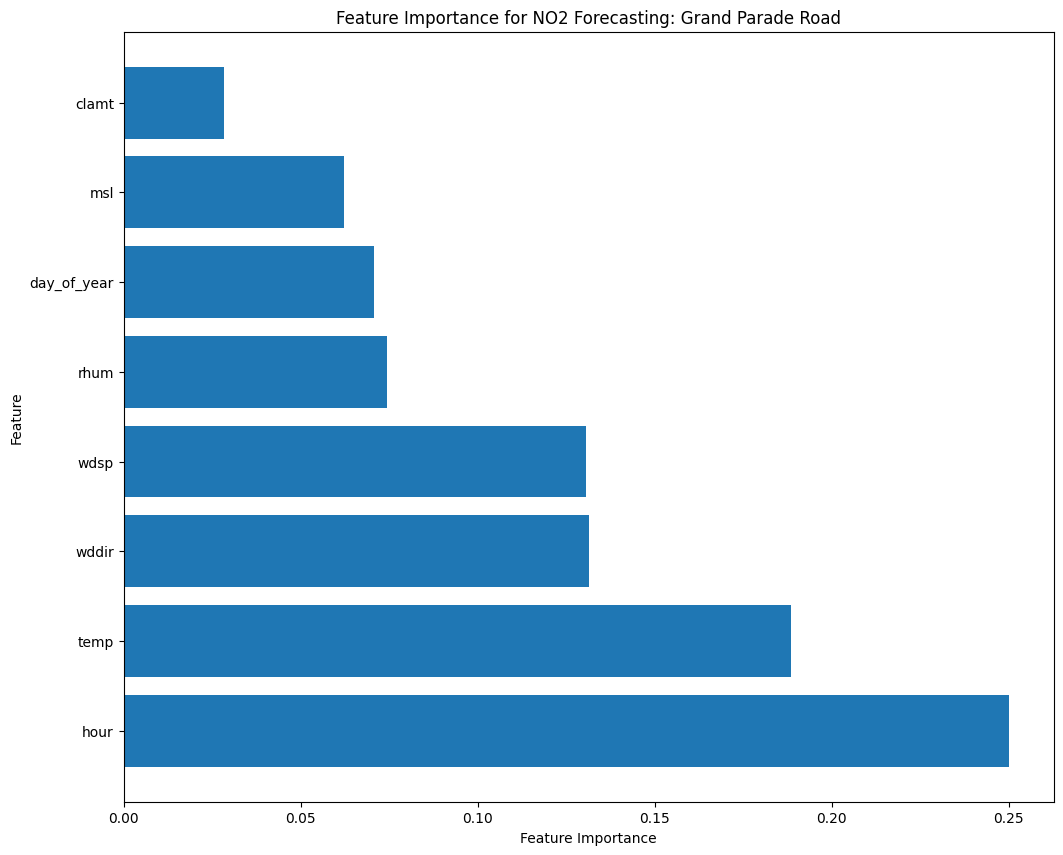

In [57]:
# updated rf feature importance
feature_importance = best_model_rf_basic.feature_importances_

# Create a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_cols_rf_basic, 'Importance': feature_importance})

# Sort features by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sub_df=feature_importance_df[~feature_importance_df['Feature'].isin(weekday_cols)]
print(feature_importance_df[~feature_importance_df['Feature'].isin(weekday_cols)])
street_name='Grand Parade Road'
# Plot feature importance
plt.figure(figsize=(12, 10))
plt.barh(sub_df['Feature'], sub_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for NO2 Forecasting: {street_name}')
plt.show()

         Feature  Importance
12  cp24_meanNO2    0.161450
13          hour    0.149743
3           wdsp    0.123316
21      PCA_car1    0.115575
0           temp    0.073933
22      PCA_hgv1    0.064215
1           rhum    0.056476
9      wddir_cos    0.055104
8      wddir_sin    0.037880
10   day_of_year    0.037182
2            msl    0.032940
4            vis    0.020940
5           clht    0.017917
6          clamt    0.014817
11    rain_log1p    0.011652
7    school_term    0.006402


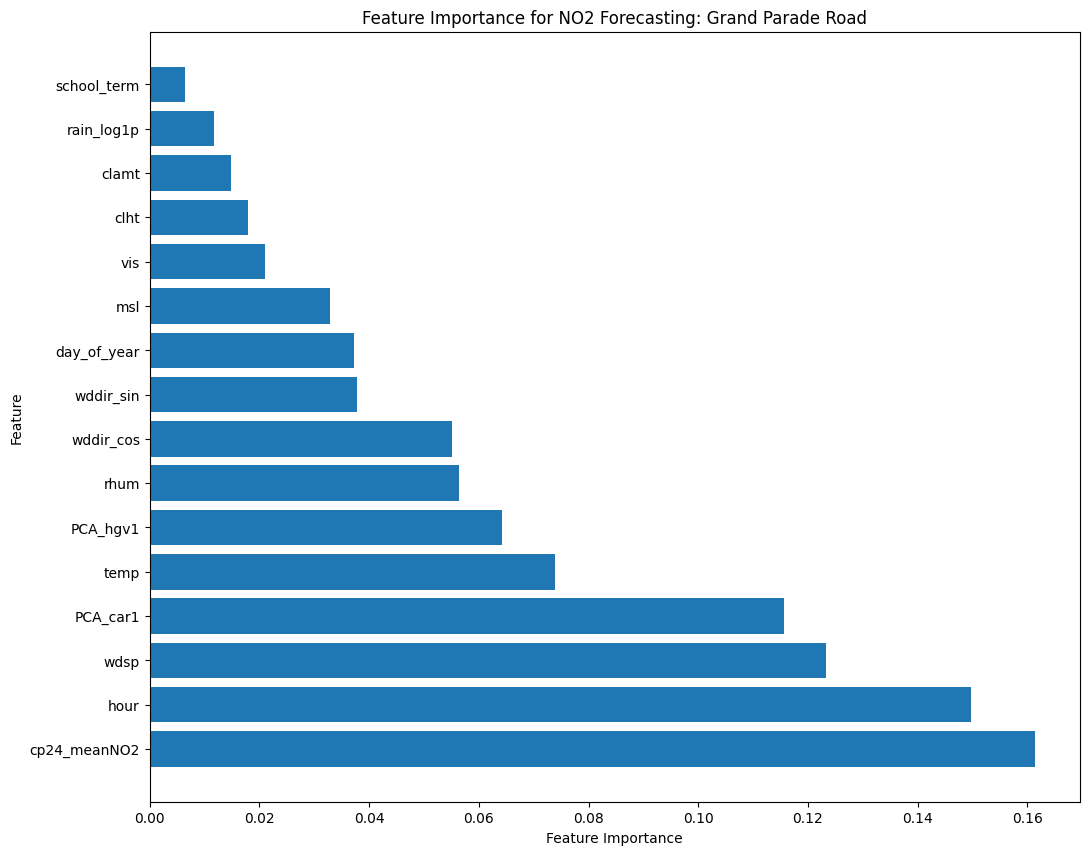

In [58]:
# updated rf feature importance
feature_importance = best_model.feature_importances_

# Create a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_cols_updated_rf, 'Importance': feature_importance})

# Sort features by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sub_df=feature_importance_df[~feature_importance_df['Feature'].isin(weekday_cols)]
print(feature_importance_df[~feature_importance_df['Feature'].isin(weekday_cols)])
street_name='Grand Parade Road'
# Plot feature importance
plt.figure(figsize=(12, 10))
plt.barh(sub_df['Feature'], sub_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for NO2 Forecasting: {street_name}')
plt.show()

In [16]:
import math

df3_copy=df1.copy()

def preprocess_data(df, target_col='NO2', pca_cols_car=['car_r1','car_r2','car_r3','car_r4'], pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):
    # Split chronologically: 70% train, 15% val, 15% test
    n = len(df)
    train_end = int(0.8 * n)
    # val_end = int(0.85 * n)
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]
    # test_df = df.iloc[val_end:]

    # PCA on selected columns (fit on train only)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)

    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])


    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index, columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        d_copy = d.drop(columns=pca_cols_car).copy()
        d_copy=pd.concat([d_copy, pca_df_car], axis=1)
        # print(d_copy.columns)
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index, columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])
        d_copy.drop(columns=pca_cols_hgv, inplace=True)
        # print(d_copy.columns)
        return pd.concat([d_copy, pca_df_hgv], axis=1)

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)
    # test_df = apply_pca(test_df)

    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_df[feature_cols])

    train_scaled_X = scaler_X.transform(train_df[feature_cols])
    val_scaled_X = scaler_X.transform(val_df[feature_cols])
    # test_scaled_X = scaler_X.transform(test_df[feature_cols])

    # Scale target
    scaler_y = MinMaxScaler()
    train_scaled_y = scaler_y.fit_transform(train_df[[target_col]])
    val_scaled_y = scaler_y.transform(val_df[[target_col]])
    # test_scaled_y = scaler_y.transform(test_df[[target_col]])

    # Rebuild DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_X, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled_X, index=val_df.index, columns=feature_cols)
    # test_scaled_df = pd.DataFrame(test_scaled_X, index=test_df.index, columns=feature_cols)

    train_scaled_df[target_col] = train_scaled_y
    val_scaled_df[target_col] = val_scaled_y
    # test_scaled_df[target_col] = test_scaled_y

    # return train_scaled_df, val_scaled_df, test_scaled_df, feature_cols
    return train_scaled_df, val_scaled_df, feature_cols


# -------------------------------
# Function to make sequences
# -------------------------------
def make_sequences(data_df, feature_cols, target_col, window_size):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

# -------------------------------
# Grid Search
# -------------------------------
candidate_windows = [24, 48, 72]
# candidate_windows = [168]

candidate_units = [16,32, 64,128]
# candidate_units = [128]

target_col = 'NO2'

train_df, val_df, feature_cols = preprocess_data(df3_copy, target_col)

results = []
for w in candidate_windows:
    # Prepare sequences for each split
    X_train, y_train = make_sequences(train_df, feature_cols, target_col, w)
    X_val, y_val = make_sequences(val_df, feature_cols, target_col, w)
    # X_test, y_test = make_sequences(test_df, feature_cols, target_col, w)

    for units in candidate_units:
        model = Sequential([
            LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.1),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=40, batch_size=32,
                            callbacks=[early_stop],
                            verbose=0)

        # RMSE calculations
        train_pred = model.predict(X_train, verbose=0).flatten()
        val_pred = model.predict(X_val, verbose=0).flatten()
        # test_pred = model.predict(X_test, verbose=0).flatten()

        rmse_train = math.sqrt(mean_squared_error(y_train, train_pred))
        rmse_val = math.sqrt(mean_squared_error(y_val, val_pred))
        # rmse_test = math.sqrt(mean_squared_error(y_test, test_pred))

        results.append((w, units, rmse_train, rmse_val))
        print(f"w={w}, units={units} -> train {rmse_train:.4f} | val {rmse_val:.4f}")

# -------------------------------
# Show as DataFrame
# -------------------------------
results_df = pd.DataFrame(results, columns=['Window', 'Units', 'Train_RMSE', 'Val_RMSE'])
print("\nHyperparameter tuning results:")
print(results_df)

w=24, units=16 -> train 0.0847 | val 0.0974
w=24, units=32 -> train 0.0833 | val 0.0954
w=24, units=64 -> train 0.0858 | val 0.0948
w=24, units=128 -> train 0.0873 | val 0.0967
w=48, units=16 -> train 0.0875 | val 0.0991
w=48, units=32 -> train 0.0843 | val 0.0965
w=48, units=64 -> train 0.0865 | val 0.1005
w=48, units=128 -> train 0.0842 | val 0.0946
w=72, units=16 -> train 0.0810 | val 0.0944
w=72, units=32 -> train 0.0811 | val 0.0954
w=72, units=64 -> train 0.0943 | val 0.0984
w=72, units=128 -> train 0.0890 | val 0.0954

Hyperparameter tuning results:
    Window  Units  Train_RMSE  Val_RMSE
0       24     16    0.084697  0.097378
1       24     32    0.083322  0.095363
2       24     64    0.085822  0.094825
3       24    128    0.087312  0.096722
4       48     16    0.087477  0.099106
5       48     32    0.084251  0.096505
6       48     64    0.086536  0.100525
7       48    128    0.084159  0.094610
8       72     16    0.080980  0.094405
9       72     32    0.081144  0.0953

In [17]:
results_df

,Window,Units,Train_RMSE,Val_RMSE
0,24,16,0.084697,0.097378
1,24,32,0.083322,0.095363
2,24,64,0.085822,0.094825
3,24,128,0.087312,0.096722
4,48,16,0.087477,0.099106
5,48,32,0.084251,0.096505
6,48,64,0.086536,0.100525
7,48,128,0.084159,0.094610
8,72,16,0.080980,0.094405
9,72,32,0.081144,0.095386


In [18]:
# Calculate overfitting percentage
results_df["Overfit_%"] = ((results_df["Val_RMSE"] - results_df["Train_RMSE"]) / results_df["Train_RMSE"]) * 100

# Mark overfitting cases where val RMSE is much worse than train (e.g., > 15%)
# threshold = 15  # you can tune this
# results_df["Overfitting_Flag"] = results_df["Overfit_%"] > threshold

# Sort to see worst offenders
results_df_sorted = results_df.sort_values(by="Overfit_%", ascending=False)

print("\nModels sorted by overfitting severity:")
print(results_df_sorted)

# # Filter out overfitting ones
# filtered_df = results_df_sorted[~results_df_sorted["Overfitting_Flag"]]
# print("\nFiltered candidates:")
# print(filtered_df)



Models sorted by overfitting severity:
    Window  Units  Train_RMSE  Val_RMSE  Overfit_%
9       72     32    0.081144  0.095386  17.551865
8       72     16    0.080980  0.094405  16.578255
6       48     64    0.086536  0.100525  16.165152
0       24     16    0.084697  0.097378  14.972350
5       48     32    0.084251  0.096505  14.545492
1       24     32    0.083322  0.095363  14.450855
4       48     16    0.087477  0.099106  13.294021
7       48    128    0.084159  0.094610  12.417574
3       24    128    0.087312  0.096722  10.777493
2       24     64    0.085822  0.094825  10.490149
11      72    128    0.088969  0.095411   7.241343
10      72     64    0.094289  0.098394   4.353861


In [19]:
import math

df3_copy=df1.copy()

def preprocess_data(df, target_col='NO2', pca_cols_car=['car_r1','car_r2','car_r3','car_r4'],pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):
    # Split chronologically: 70% train, 15% val, 15% test
    n = len(df)
    train_end = int(0.8 * n)
    # val_end = int(0.85 * n)
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]
    # test_df = df.iloc[val_end:]

    # PCA on selected columns (fit on train only)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)

    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])


    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index, columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        d_copy = d.drop(columns=pca_cols_car).copy()
        d_copy=pd.concat([d_copy, pca_df_car], axis=1)
    
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index, columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])
        d_copy.drop(columns=pca_cols_hgv, inplace=True)

        return pd.concat([d_copy, pca_df_hgv], axis=1)

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)
    # test_df = apply_pca(test_df)

    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_df[feature_cols])

    train_scaled_X = scaler_X.transform(train_df[feature_cols])
    val_scaled_X = scaler_X.transform(val_df[feature_cols])
    # test_scaled_X = scaler_X.transform(test_df[feature_cols])

    # Scale target
    scaler_y = MinMaxScaler()
    train_scaled_y = scaler_y.fit_transform(train_df[[target_col]])
    val_scaled_y = scaler_y.transform(val_df[[target_col]])
    # test_scaled_y = scaler_y.transform(test_df[[target_col]])

    # Rebuild DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_X, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled_X, index=val_df.index, columns=feature_cols)
    # test_scaled_df = pd.DataFrame(test_scaled_X, index=test_df.index, columns=feature_cols)

    train_scaled_df[target_col] = train_scaled_y
    val_scaled_df[target_col] = val_scaled_y
    # test_scaled_df[target_col] = test_scaled_y

    # return train_scaled_df, val_scaled_df, test_scaled_df, feature_cols
    return train_scaled_df, val_scaled_df, feature_cols


# -------------------------------
# Function to make sequences
# -------------------------------
def make_sequences(data_df, feature_cols, target_col, window_size):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

# -------------------------------
# Grid Search
# -------------------------------
candidate_windows = [24, 48, 72]
candidate_units = [32, 64,128]
target_col = 'NO2'

train_df, val_df, feature_cols = preprocess_data(df3_copy, target_col)

results = []

for w in candidate_windows:
    # Prepare sequences for each split
    X_train, y_train = make_sequences(train_df, feature_cols, target_col, w)
    X_val, y_val = make_sequences(val_df, feature_cols, target_col, w)
    # X_test, y_test = make_sequences(test_df, feature_cols, target_col, w)

    for units in candidate_units:
        model = Sequential([
            LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.1),
            LSTM(units//2),
            Dropout(0.1),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=60, batch_size=32,
                            callbacks=[early_stop],
                            verbose=0)

        # RMSE calculations
        train_pred = model.predict(X_train, verbose=0).flatten()
        val_pred = model.predict(X_val, verbose=0).flatten()
        # test_pred = model.predict(X_test, verbose=0).flatten()

        rmse_train = math.sqrt(mean_squared_error(y_train, train_pred))
        rmse_val = math.sqrt(mean_squared_error(y_val, val_pred))
        # rmse_test = math.sqrt(mean_squared_error(y_test, test_pred))

        results.append((w, units, rmse_train, rmse_val))
        print(f"w={w}, units={units} -> train {rmse_train:.4f} | val {rmse_val:.4f}")

# -------------------------------
# Show as DataFrame
# -------------------------------
results_df = pd.DataFrame(results, columns=['Window', 'Units', 'Train_RMSE', 'Val_RMSE'])
print("\nHyperparameter tuning results:")
print(results_df)

w=24, units=32 -> train 0.0862 | val 0.0970
w=24, units=64 -> train 0.0873 | val 0.0962
w=24, units=128 -> train 0.0859 | val 0.0941
w=48, units=32 -> train 0.0869 | val 0.0989
w=48, units=64 -> train 0.0809 | val 0.0958
w=48, units=128 -> train 0.0843 | val 0.0943
w=72, units=32 -> train 0.0839 | val 0.0936
w=72, units=64 -> train 0.0827 | val 0.1006
w=72, units=128 -> train 0.0799 | val 0.0976

Hyperparameter tuning results:
   Window  Units  Train_RMSE  Val_RMSE
0      24     32    0.086165  0.096987
1      24     64    0.087314  0.096235
2      24    128    0.085943  0.094105
3      48     32    0.086873  0.098874
4      48     64    0.080859  0.095766
5      48    128    0.084343  0.094289
6      72     32    0.083869  0.093582
7      72     64    0.082670  0.100589
8      72    128    0.079861  0.097569


In [20]:
# Calculate overfitting percentage
results_df["Overfit_%"] = ((results_df["Val_RMSE"] - results_df["Train_RMSE"]) / results_df["Train_RMSE"]) * 100

# Mark overfitting cases where val RMSE is much worse than train (e.g., > 15%)
# threshold = 15  # you can tune this
# results_df["Overfitting_Flag"] = results_df["Overfit_%"] > threshold

# Sort to see worst offenders
results_df_sorted = results_df.sort_values(by="Overfit_%", ascending=False)

print("\nModels sorted by overfitting severity:")
results_df_sorted

# # Filter out overfitting ones
# filtered_df_adv = results_df_sorted[~results_df_sorted["Overfitting_Flag"]]
# print("\nFiltered candidates:")
# print(filtered_df_adv)


Models sorted by overfitting severity:


,Window,Units,Train_RMSE,Val_RMSE,Overfit_%
8,72,128,0.079861,0.097569,22.174255
7,72,64,0.082670,0.100589,21.676132
4,48,64,0.080859,0.095766,18.436156
3,48,32,0.086873,0.098874,13.814773
0,24,32,0.086165,0.096987,12.560188
5,48,128,0.084343,0.094289,11.791977
6,72,32,0.083869,0.093582,11.581541
1,24,64,0.087314,0.096235,10.217423
2,24,128,0.085943,0.094105,9.497271


In [21]:
print(results_df_sorted)


   Window  Units  Train_RMSE  Val_RMSE  Overfit_%
8      72    128    0.079861  0.097569  22.174255
7      72     64    0.082670  0.100589  21.676132
4      48     64    0.080859  0.095766  18.436156
3      48     32    0.086873  0.098874  13.814773
0      24     32    0.086165  0.096987  12.560188
5      48    128    0.084343  0.094289  11.791977
6      72     32    0.083869  0.093582  11.581541
1      24     64    0.087314  0.096235  10.217423
2      24    128    0.085943  0.094105   9.497271


In [22]:
df4.tail()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,station,hour,date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-30 19:00:00+01:00,14.4,71,1018.9,10,40000,70.0,7,17.645667,1,-0.939693,...,OP,19,2024-06-30,0,0,0,0,0,0,1
2024-06-30 20:00:00+01:00,13.2,80,1019.4,10,35000,60.0,7,19.991724,1,-0.642788,...,OP,20,2024-06-30,0,0,0,0,0,0,1
2024-06-30 21:00:00+01:00,12.2,89,1019.5,8,35000,60.0,7,19.596000,1,-0.939693,...,OP,21,2024-06-30,0,0,0,0,0,0,1
2024-06-30 22:00:00+01:00,11.9,89,1020.3,8,30000,12.0,7,16.278333,1,-0.866025,...,OP,22,2024-06-30,0,0,0,0,0,0,1
2024-06-30 23:00:00+01:00,12.1,88,1020.6,5,30000,50.0,7,17.937167,1,-0.866025,...,OP,23,2024-06-30,0,0,0,0,0,0,1


In [524]:
len(df4)

7396

In [525]:
df3_copy.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r4,cp24_meanNO2,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-06 18:00:00+01:00,17.7,55,1022.7,13,40000,20.0,3,4.498000,0,-0.939693,...,55,12.350705,18,0,0,0,0,0,0,1
2023-08-06 19:00:00+01:00,17.4,53,1023.1,12,40000,20.0,3,8.257000,0,-0.866025,...,45,12.350705,19,0,0,0,0,0,0,1
2023-08-06 20:00:00+01:00,15.8,62,1023.4,10,40000,40.0,6,18.923333,0,-0.866025,...,41,12.350705,20,0,0,0,0,0,0,1
2023-08-06 21:00:00+01:00,14.8,62,1023.7,10,40000,20.0,3,20.053333,0,-0.866025,...,33,12.350705,21,0,0,0,0,0,0,1
2023-08-06 22:00:00+01:00,13.5,71,1024.1,4,40000,20.0,1,19.938000,0,-0.984808,...,34,12.350705,22,0,0,0,0,0,0,1


In [23]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df3_copy=df1.copy()
def preprocess_data(df, target_col='NO2', pca_cols_car=['car_r1','car_r2','car_r3','car_r4'],pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):
    # Split chronologically: 70% train, 15% val, 15% test
    n = len(df)
    
    train_end = int(0.8 * n)
    # val_end = int(0.85 * n)
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]
    # test_df = df.iloc[val_end:]

    # PCA on selected columns (fit on train only)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)

    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])


    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index, columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        d_copy = d.drop(columns=pca_cols_car).copy()
        d_copy=pd.concat([d_copy, pca_df_car], axis=1)
    
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index, columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])
        d_copy.drop(columns=pca_cols_hgv, inplace=True)

        return pd.concat([d_copy, pca_df_hgv], axis=1)

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)
    # test_df = apply_pca(test_df)

    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_df[feature_cols])

    train_scaled_X = scaler_X.transform(train_df[feature_cols])
    val_scaled_X = scaler_X.transform(val_df[feature_cols])
    # test_scaled_X = scaler_X.transform(test_df[feature_cols])

    # Scale target
    scaler_y = MinMaxScaler()
    train_scaled_y = scaler_y.fit_transform(train_df[[target_col]])
    val_scaled_y = scaler_y.transform(val_df[[target_col]])
    # test_scaled_y = scaler_y.transform(test_df[[target_col]])

    # Rebuild DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_X, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled_X, index=val_df.index, columns=feature_cols)
    # test_scaled_df = pd.DataFrame(test_scaled_X, index=test_df.index, columns=feature_cols)

    train_scaled_df[target_col] = train_scaled_y
    val_scaled_df[target_col] = val_scaled_y
    # test_scaled_df[target_col] = test_scaled_y

    # return train_scaled_df, val_scaled_df, test_scaled_df, feature_cols
    return train_scaled_df, val_scaled_df, feature_cols,scaler_y,scaler_X,pca_car,pca_hgv


# -------------------------------
# Function to make sequences
# -------------------------------
def make_sequences(data_df, feature_cols, target_col, window_size=48):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

target_col = 'NO2'

train_df_b1, val_df_b1, feature_cols_basic,scaler_y_basic1,scaler_X_basic1, pca_car_basic,pca_hgv_basic = preprocess_data(df3_copy, target_col)

X_train, y_train = make_sequences(train_df_b1, feature_cols_basic, target_col)
X_val, y_val = make_sequences(val_df_b1, feature_cols_basic, target_col)
# X_test, y_test = make_sequences(test_df, feature_cols, target_col)


basic_model1 = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.1),
        Dense(1)
    ])
basic_model1.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = basic_model1.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80, batch_size=32,
    callbacks=[early_stop],
    verbose=0)


y_pred_scaled = basic_model1.predict(X_val)

# Inverse transform predictions and actual values
y_pred = scaler_y_basic1.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y_basic1.inverse_transform(y_val.reshape(-1, 1)).ravel()

mae_bm1 = mean_absolute_error(y_true, y_pred)
rmse_bm1 = sqrt(mean_squared_error(y_true, y_pred))
r2_bm1 = r2_score(y_true, y_pred)

print(f"LSTM performance)")
print(f"MAE: {mae_bm1:.2f} | RMSE: {rmse_bm1:.2f} | R²: {r2_bm1:.2f}")




64/64 [==============================] - 1s 13ms/step
LSTM performance)
MAE: 7.43 | RMSE: 10.70 | R²: 0.66


In [238]:
feature_cols_basic

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'cp24_meanNO2',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'hour_sin',
 'hour_cos',
 'PCA_car1',
 'PCA_hgv1']

In [464]:
val_df.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-15 18:00:00+00:00,0.505703,0.254545,0.533246,0.114286,0.713877,0.076305,0.000000,1.0,0.116978,0.821394,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.500000,0.746256,0.289079,0.374955
2024-03-15 19:00:00+00:00,0.452471,0.381818,0.544980,0.028571,0.713877,0.076305,0.000000,1.0,0.116978,0.821394,...,0.0,0.0,1.0,0.0,0.0,0.017037,0.629410,0.634675,0.222028,0.582373
2024-03-15 20:00:00+00:00,0.422053,0.436364,0.554107,0.028571,0.427754,0.076305,0.142857,1.0,0.250000,0.933013,...,0.0,0.0,1.0,0.0,0.0,0.066987,0.750000,0.448790,0.131591,0.702557
2024-03-15 21:00:00+00:00,0.372624,0.527273,0.567145,0.028571,0.284692,0.152610,0.714286,1.0,0.992404,0.586824,...,0.0,0.0,1.0,0.0,0.0,0.146447,0.853553,0.368855,0.102249,0.668167
2024-03-15 22:00:00+00:00,0.380228,0.527273,0.571056,0.057143,0.284692,0.140562,0.714286,1.0,0.671010,0.030154,...,0.0,0.0,1.0,0.0,0.0,0.250000,0.933013,0.289962,0.087183,0.629096


In [108]:
df3_copy.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'hour'],
      dtype='object')

In [24]:
# # Get radians from sin/cos
# hour_rad = np.arctan2(df3['hour_sin'], df3['hour_cos'])

# # Convert back to [0, 24) hours
# hour = (hour_rad % (2 * np.pi)) * 24 / (2 * np.pi)

# df3_copy=df3.drop(columns=['hour_sin','hour_cos'])
# df3_copy['hour']=hour

df3_copy=df1.copy()
def preprocess_data(df, target_col='NO2', pca_cols_car=['car_r1','car_r2','car_r3','car_r4'],pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):
    # Split chronologically: 70% train, 15% val, 15% test
    n = len(df)
    
    train_end = int(0.8 * n)
    # val_end = int(0.85 * n)
    
    train_df = df.iloc[:train_end]
    
    val_df = df.iloc[train_end:]
    # test_df = df.iloc[val_end:]

    # PCA on selected columns (fit on train only)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)

    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])


    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index, columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        d_copy = d.drop(columns=pca_cols_car).copy()
        d_copy=pd.concat([d_copy, pca_df_car], axis=1)
    
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index, columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])
        d_copy.drop(columns=pca_cols_hgv, inplace=True)

        return pd.concat([d_copy, pca_df_hgv], axis=1)

    train_df = apply_pca(train_df)

    val_df = apply_pca(val_df)
    # test_df = apply_pca(test_df)

    
    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_df[feature_cols])

    train_scaled_X = scaler_X.transform(train_df[feature_cols])

    val_scaled_X = scaler_X.transform(val_df[feature_cols])
    # test_scaled_X = scaler_X.transform(test_df[feature_cols])

    # Scale target
    scaler_y = MinMaxScaler()
    train_scaled_y = scaler_y.fit_transform(train_df[[target_col]])
    val_scaled_y = scaler_y.transform(val_df[[target_col]])
    # test_scaled_y = scaler_y.transform(test_df[[target_col]])

    # Rebuild DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_X, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled_X, index=val_df.index, columns=feature_cols)
    # test_scaled_df = pd.DataFrame(test_scaled_X, index=test_df.index, columns=feature_cols)

    train_scaled_df[target_col] = train_scaled_y
    val_scaled_df[target_col] = val_scaled_y
    # test_scaled_df[target_col] = test_scaled_y
    print(train_scaled_df.columns)

    # return train_scaled_df, val_scaled_df, test_scaled_df, feature_cols
    return train_scaled_df, val_scaled_df, feature_cols,scaler_y,scaler_X,pca_car,pca_hgv


# -------------------------------
# Function to make sequences
# -------------------------------
def make_sequences(data_df, feature_cols, target_col, window_size=24):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

target_col = 'NO2'

train_df_b2, val_df_b2, feature_cols_basic,scaler_y_basic2,scaler_X_basic2, pca_car_basic,pca_hgv_basic = preprocess_data(df3_copy, target_col)
print(feature_cols_basic)
X_train, y_train = make_sequences(train_df_b2, feature_cols_basic, target_col)
X_val, y_val = make_sequences(val_df_b2, feature_cols_basic, target_col)
# X_test, y_test = make_sequences(test_df, feature_cols, target_col)


basic_model2 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.1),
        Dense(1)
    ])
basic_model2.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = basic_model2.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80, batch_size=32,
    callbacks=[early_stop],
    verbose=0)

y_pred_scaled = basic_model2.predict(X_val)

# Inverse transform predictions and actual values
y_pred = scaler_y_basic2.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y_basic2.inverse_transform(y_val.reshape(-1, 1)).ravel()

mae_bm2 = mean_absolute_error(y_true, y_pred)
rmse_bm2 = sqrt(mean_squared_error(y_true, y_pred))
r2_bm2 = r2_score(y_true, y_pred)

print(f"LSTM performance)")
print(f"MAE: {mae_bm2:.2f} | RMSE: {rmse_bm2:.2f} | R²: {r2_bm2:.2f}")




Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'school_term',
       'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p', 'cp24_meanNO2',
       'hour', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'PCA_car1', 'PCA_hgv1', 'NO2'],
      dtype='object')
['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p', 'cp24_meanNO2', 'hour', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'PCA_car1', 'PCA_hgv1']
65/65 [==============================] - 1s 5ms/step
LSTM performance)
MAE: 7.38 | RMSE: 10.65 | R²: 0.66


In [134]:
train_df_b2.iloc[3750:,]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-15 01:00:00+00:00,0.414530,0.877193,0.473190,0.419355,0.170243,0.028112,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.047919,0.031260,0.106482,2024-03-15
2024-03-15 02:00:00+00:00,0.418803,0.894737,0.475871,0.322581,0.170243,0.032129,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.035587,0.044730,0.134621,2024-03-15
2024-03-15 03:00:00+00:00,0.397436,0.929825,0.477212,0.290323,0.127325,0.032129,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.030714,0.079303,0.093333,2024-03-15
2024-03-15 04:00:00+00:00,0.397436,0.947368,0.474531,0.290323,0.127325,0.012048,0.857143,1.0,0.178606,0.116978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.038853,0.091497,0.102256,2024-03-15
2024-03-15 05:00:00+00:00,0.397436,0.947368,0.477212,0.322581,0.113019,0.016064,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.101697,0.200761,0.180487,2024-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08 18:00:00+01:00,0.594017,0.631579,0.873995,0.258065,0.570815,0.558233,0.857143,1.0,0.413176,0.007596,...,0.0,1.0,0.0,0.0,0.0,0.0,0.850220,0.464434,0.080400,2024-05-08
2024-05-08 19:00:00+01:00,0.555556,0.596491,0.872654,0.225806,0.570815,0.518072,0.428571,1.0,0.500000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.608960,0.294806,0.109590,2024-05-08
2024-05-08 20:00:00+01:00,0.508547,0.754386,0.876676,0.193548,0.570815,0.799197,0.428571,1.0,0.500000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.459168,0.204544,0.238987,2024-05-08


In [528]:
df3_copy.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2', 'hour', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'],
      dtype='object')

In [25]:
df3_copy=df1.copy()
def preprocess_data(df, target_col='NO2', pca_cols_car=['car_r1','car_r2','car_r3','car_r4'],pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):
    # Split chronologically: 70% train, 15% val, 15% test
    n = len(df)
    train_end = int(0.8 * n)
    # val_end = int(0.85 * n)
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]
    # test_df = df.iloc[val_end:]

    # PCA on selected columns (fit on train only)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)

    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])


    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index, columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        d_copy = d.drop(columns=pca_cols_car).copy()
        d_copy=pd.concat([d_copy, pca_df_car], axis=1)
    
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index, columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])
        d_copy.drop(columns=pca_cols_hgv, inplace=True)

        return pd.concat([d_copy, pca_df_hgv], axis=1)

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)
    # test_df = apply_pca(test_df)

    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_df[feature_cols])

    train_scaled_X = scaler_X.transform(train_df[feature_cols])
    val_scaled_X = scaler_X.transform(val_df[feature_cols])
    # test_scaled_X = scaler_X.transform(test_df[feature_cols])

    # Scale target
    scaler_y = MinMaxScaler()
    train_scaled_y = scaler_y.fit_transform(train_df[[target_col]])
    val_scaled_y = scaler_y.transform(val_df[[target_col]])
    # test_scaled_y = scaler_y.transform(test_df[[target_col]])

    # Rebuild DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_X, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled_X, index=val_df.index, columns=feature_cols)
    # test_scaled_df = pd.DataFrame(test_scaled_X, index=test_df.index, columns=feature_cols)

    train_scaled_df[target_col] = train_scaled_y
    val_scaled_df[target_col] = val_scaled_y
    # test_scaled_df[target_col] = test_scaled_y

    # return train_scaled_df, val_scaled_df, test_scaled_df, feature_cols, scaler_y
    return train_scaled_df, val_scaled_df, feature_cols, scaler_y,scaler_X,pca_car,pca_hgv


# -------------------------------
# Function to make sequences
# -------------------------------
def make_sequences(data_df, feature_cols, target_col, window_size=72):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

target_col = 'NO2'

train_df_a1, val_df_a1,  feature_cols_adv, scaler_y_adv1,scaler_X_adv1,pca_adv_car,pca_adv_hgv = preprocess_data(df3_copy, target_col)

X_train, y_train = make_sequences(train_df_a1, feature_cols_adv, target_col)
X_val, y_val = make_sequences(val_df_a1, feature_cols_adv, target_col)
# X_test, y_test = make_sequences(test_df, feature_cols, target_col)


adv_model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(16),
    Dropout(0.1),
    Dense(1)
        ])
adv_model.compile(optimizer='adam', loss='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = adv_model.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80, batch_size=32,
    callbacks=[early_stop],
    verbose=0)

y_pred_scaled = adv_model.predict(X_val)

# Inverse transform predictions and actual values
y_pred = scaler_y_adv1.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y_adv1.inverse_transform(y_val.reshape(-1, 1)).ravel()

mae_adv1 = mean_absolute_error(y_true, y_pred)
rmse_adv1 = sqrt(mean_squared_error(y_true, y_pred))
r2_adv1 = r2_score(y_true, y_pred)

print(f"LSTM performance)")
print(f"MAE: {mae_adv1:.2f} | RMSE: {rmse_adv1:.2f} | R²: {r2_adv1:.2f}")



64/64 [==============================] - 1s 10ms/step
LSTM performance)
MAE: 7.45 | RMSE: 11.08 | R²: 0.63


In [320]:
mae_adv1 = mean_absolute_error(y_true, y_pred)
rmse_adv1 = sqrt(mean_squared_error(y_true, y_pred))
r2_adv1 = r2_score(y_true, y_pred)

print(f"LSTM performance)")
print(f"MAE: {mae_adv1:.2f} | RMSE: {rmse_adv1:.2f} | R²: {r2_adv1:.2f}")


LSTM performance)
MAE: 7.53 | RMSE: 12.35 | R²: 0.54


In [26]:
df3_copy=df1.copy()
def preprocess_data(df, target_col='NO2', pca_cols_car=['car_r1','car_r2','car_r3','car_r4'],pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):

    n = len(df)
    train_end = int(0.8 * n)
    # val_end = int(0.85 * n)
    
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:]
    # test_df = df.iloc[val_end:]

    # PCA on selected columns (fit on train only)
    pca_car = PCA(n_components=n_pca_components)
    pca_hgv = PCA(n_components=n_pca_components)

    pca_car.fit(train_df[pca_cols_car])
    pca_hgv.fit(train_df[pca_cols_hgv])


    def apply_pca(d):
        transformed_car = pca_car.transform(d[pca_cols_car])
        transformed_hgv = pca_hgv.transform(d[pca_cols_hgv])

        pca_df_car = pd.DataFrame(transformed_car, index=d.index, columns=[f'PCA_car{i+1}' for i in range(n_pca_components)])
        d_copy = d.drop(columns=pca_cols_car).copy()
        d_copy=pd.concat([d_copy, pca_df_car], axis=1)
    
        pca_df_hgv = pd.DataFrame(transformed_hgv, index=d.index, columns=[f'PCA_hgv{i+1}' for i in range(n_pca_components)])
        d_copy.drop(columns=pca_cols_hgv, inplace=True)

        return pd.concat([d_copy, pca_df_hgv], axis=1)

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)
    # test_df = apply_pca(test_df)

    # MinMax scale features (fit on train only)
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_df[feature_cols])

    train_scaled_X = scaler_X.transform(train_df[feature_cols])
    val_scaled_X = scaler_X.transform(val_df[feature_cols])
    # test_scaled_X = scaler_X.transform(test_df[feature_cols])

    # Scale target
    scaler_y = MinMaxScaler()
    train_scaled_y = scaler_y.fit_transform(train_df[[target_col]])
    val_scaled_y = scaler_y.transform(val_df[[target_col]])
    # test_scaled_y = scaler_y.transform(test_df[[target_col]])

    # Rebuild DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_X, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled_X, index=val_df.index, columns=feature_cols)
    # test_scaled_df = pd.DataFrame(test_scaled_X, index=test_df.index, columns=feature_cols)

    train_scaled_df[target_col] = train_scaled_y
    val_scaled_df[target_col] = val_scaled_y
    # test_scaled_df[target_col] = test_scaled_y

    # return train_scaled_df, val_scaled_df, test_scaled_df, feature_cols, scaler_y
    return train_scaled_df, val_scaled_df, feature_cols, scaler_y,scaler_X, pca_car,pca_hgv


# -------------------------------
# Function to make sequences
# -------------------------------
def make_sequences(data_df, feature_cols, target_col, window_size=48):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

target_col = 'NO2'

train_df_a2, val_df_a2, feature_cols, scaler_y_adv2,scaler_X_adv2, pca2_car,pca2_hgv = preprocess_data(df3_copy, target_col)

X_train, y_train = make_sequences(train_df_a2, feature_cols, target_col)
X_val, y_val = make_sequences(val_df_a2, feature_cols, target_col)
# X_test, y_test = make_sequences(test_df, feature_cols, target_col)


adv_model2 = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.1),
            LSTM(64),
            Dense(1)
        ])
adv_model2.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = adv_model2.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80, batch_size=32,
    callbacks=[early_stop],
    verbose=0)



y_pred_scaled = adv_model2.predict(X_val)

# Inverse transform predictions and actual values
y_pred = scaler_y_adv2.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y_adv2.inverse_transform(y_val.reshape(-1, 1)).ravel()

mae_adv2 = mean_absolute_error(y_true, y_pred)
rmse_adv2 = sqrt(mean_squared_error(y_true, y_pred))
r2_adv2 = r2_score(y_true, y_pred)

print(f"LSTM performance)")
print(f"MAE: {mae_adv2:.2f} | RMSE: {rmse_adv2:.2f} | R²: {r2_adv2:.2f}")


64/64 [==============================] - 2s 23ms/step
LSTM performance)
MAE: 7.43 | RMSE: 11.23 | R²: 0.62


In [27]:
!pip install shap

   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
    --------------------------------------- 10.2/544.4 kB ? eta -:--:--
   -- ------------------------------------ 30.7/544.4 kB 435.7 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/544.4 kB 393.8 kB/s eta 0:00:02
   ---- ---------------------------------- 61.4/544.4 kB 328.2 kB/s eta 0:00:02
   ---- ---------------------------------- 61.4/544.4 kB 328.2 kB/s eta 0:00:02
   ---------- --------------------------- 143.4/544.4 kB 532.5 kB/s eta 0:00:01
   ---------- --------------------------- 153.6/544.4 kB 482.7 kB/s eta 0:00:01
   ------------ ------------------------- 174.1/544.4 kB 499.5 kB/s eta 0:00:01
   ---------------- --------------------- 235.5/544.4 kB 577.6 kB/s eta 0:00:01
   ---------------- --------------------- 235.5/544.4 kB 577.6 kB/s eta 0:00:01
   ---------------- --------------------- 235.5/544.4 kB 577.6 kB/s eta 0:00:01
   ----------------- -------------------- 256.0/544.4 kB 


[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# ==============================
# SHAP for your trained LSTM (robust version)
# ==============================
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1) Read expected (T, F) from your trained model and (re)build sequences if needed
_, T_expected, F_expected = adv_model.input_shape  # e.g., (None, 72, 23)
print("Model expects window, features:", (T_expected, F_expected))

def ensure_seq_shapes(train_df, val_df, feat_cols, target, T):
    Xtr, ytr = make_sequences(train_df, feat_cols, target, window_size=T)
    Xva, yva = make_sequences(val_df,   feat_cols, target, window_size=T)
    return Xtr, ytr, Xva, yva

if (X_train.shape[1] != T_expected) or (X_train.shape[2] != F_expected):
    print("Rebuilding sequences to match the model…")
    X_train, y_train, X_val, y_val = ensure_seq_shapes(train_df_a1, val_df_a1, feature_cols_adv, target_col, T_expected)

print("X_train:", X_train.shape, "X_val:", X_val.shape)  # should be (?, T_expected, F_expected)

# 2) Build background (from TRAIN) and a manageable validation slice
bg_n = min(128, X_train.shape[0])
bg_idx = np.random.choice(X_train.shape[0], bg_n, replace=False)
background = X_train[bg_idx]                    # (bg_n, T, F)

M_max = min(500, X_val.shape[0])
Xv = X_val[:M_max]                              # (M, T, F)

# 3) Try GradientExplainer first; if it fails, fall back to KernelExplainer
use_kernel = False
try:
    print("Trying SHAP GradientExplainer…")
    explainer = shap.GradientExplainer(adv_model, background)
    shap_values = explainer.shap_values(Xv)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]            # (M, T, F) for single-output regression
    print("GradientExplainer OK:", shap_values.shape)
except Exception as e:
    print("GradientExplainer failed -> falling back to KernelExplainer.\nReason:", repr(e))
    use_kernel = True

if use_kernel:
    # KernelExplainer needs 2D inputs; we flatten (T*F) and wrap a predictor
    M, T, F = Xv.shape
    Xv2d = Xv.reshape(M, T * F)
    bg2d = background.reshape(background.shape[0], T * F)

    # Prediction function that reshapes back to (M, T, F)
    f = lambda x: adv_model.predict(x.reshape(-1, T_expected, F_expected)).ravel()

    # Use a small subset for KernelExplainer (it’s slow)
    subs = min(150, M)   # adjust if needed
    print(f"KernelExplainer on {subs} samples…")
    kexpl = shap.KernelExplainer(f, bg2d)
    ksv = kexpl.shap_values(Xv2d[:subs], l1_reg="num_features(20)")
    # ksv is a list for single-output regression with one array of shape (subs, T*F)
    if isinstance(ksv, list):
        ksv = ksv[0]
    shap_values = ksv.reshape(subs, T_expected, F_expected)
    Xv = Xv[:subs]
    print("KernelExplainer OK:", shap_values.shape)

# 4) Global feature importance (collapse time dimension)
F = Xv.shape[2]
shap.summary_plot(
    shap_values.reshape(-1, F),     # (M*T, F): SHAP per feature across all timesteps
    Xv.reshape(-1, F),              # values flattened in the same way
    feature_names=feature_cols_adv
)

# 5) Local explanation: average SHAP over time for one sample
k = 0
shap.force_plot(
    getattr(explainer, "expected_value", [0])[0] if not use_kernel else np.mean(adv_model.predict(background)),
    shap_values[k].mean(axis=0),    # (F,)
    Xv[k].mean(axis=0),             # (F,)
    feature_names=feature_cols_adv,
    matplotlib=True
)
plt.show()

# 6) (Optional) Which timesteps matter most overall?
time_importance = np.mean(np.abs(shap_values), axis=2)   # (M, T)
plt.figure()
plt.plot(np.arange(1, Xv.shape[1] + 1), np.mean(time_importance, axis=0))
plt.xlabel("Timestep within window")
plt.ylabel("Mean |SHAP|")
plt.title("Temporal importance profile")
plt.show()


Model expects window, features: (72, 23)
X_train: (8297, 72, 23) X_val: (2021, 72, 23)
Trying SHAP GradientExplainer…
GradientExplainer failed -> falling back to KernelExplainer.
Reason: StagingError('in user code:\n\n    File "c:\\Python\\Python311\\Lib\\site-packages\\shap\\explainers\\_gradient.py", line 250, in grad_graph  *\n        x_grad = tape.gradient(out, x)\n\n    LookupError: gradient registry has no entry for: shap_StridedSlice\n')
KernelExplainer on 150 samples…
4/4 [==============================] - 0s 20ms/step


Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


MemoryError: Unable to allocate 8.46 GiB for an array with shape (5360, 211968) and data type float64

In [28]:
train_df_a1.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'school_term',
       'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p', 'cp24_meanNO2',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'hour_sin', 'hour_cos', 'PCA_car1',
       'PCA_hgv1', 'NO2'],
      dtype='object')

In [118]:
cfd

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,11.340000,1,-0.984808,...,63.0,94,25,17.674167,LG,0,2023-09-22,1,0,0
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,8.420000,1,-0.984808,...,48.0,68,19,17.674167,LG,1,2023-09-22,1,0,0
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,7.530000,1,-0.984808,...,58.0,77,18,17.674167,LG,2,2023-09-22,1,0,0
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,11.590000,1,-0.984808,...,68.0,77,25,17.674167,LG,3,2023-09-22,1,0,0
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,11.560000,1,-0.866025,...,67.0,65,47,17.674167,LG,4,2023-09-22,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24 19:00:00+01:00,14.0,89,1003.6,16,25000,40.0,5,5.723000,1,-0.766044,...,85.0,888,61,6.458662,GP,19,2023-09-24,0,0,1
2023-09-24 20:00:00+01:00,13.8,91,1004.6,15,25000,40.0,5,5.581667,1,-0.500000,...,58.0,647,46,6.458662,GP,20,2023-09-24,0,0,1
2023-09-24 21:00:00+01:00,13.8,94,1005.3,16,20000,10.0,7,5.240667,1,-0.500000,...,35.0,398,43,6.458662,GP,21,2023-09-24,0,0,1


In [119]:
# # pd.to_datetime(df1.index).dt.date
# df1['date']=pd.Series(df1.index).dt.date
# df1[((df1['date']>=pd.to_datetime('2023-03-15').date()) & (df1['date']<=pd.to_datetime('2023-03-18').date()) )]
# df1[((df1['date']>=pd.to_datetime('2023-03-15').date()) & (df1['date']<=pd.to_datetime('2023-03-18').date()) )]


In [120]:
osd2.head()

NameError: name 'osd2' is not defined

In [121]:
osd1.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date,weekday_1,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-18 00:00:00+01:00,13.8,94,1015.4,7,8000,5.0,7,14.46,1,-0.642788,...,47.0,180,38,31.603573,LG,0,2024-05-18,0,1,0
2024-05-18 01:00:00+01:00,13.7,95,1015.5,10,8000,4.0,7,11.32,1,-0.342020,...,29.0,131,24,31.603573,LG,1,2024-05-18,0,1,0
2024-05-18 02:00:00+01:00,12.6,94,1015.6,11,8000,4.0,7,7.64,1,-0.642788,...,31.0,67,20,31.603573,LG,2,2024-05-18,0,1,0
2024-05-18 03:00:00+01:00,12.3,95,1015.7,10,8000,5.0,7,9.85,1,-0.642788,...,34.0,69,34,31.603573,LG,3,2024-05-18,0,1,0
2024-05-18 04:00:00+01:00,11.9,95,1015.7,12,8000,5.0,7,6.97,1,-0.342020,...,40.0,77,24,31.603573,LG,4,2024-05-18,0,1,0


In [39]:
spd_24.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'weekday_iso', 'wddir_sin', 'wddir_cos', 'day_of_year',
       'rain_log1p', 'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3',
       'hgv_r3', 'car_r4', 'hgv_r4', 'cp24_meanNO2', 'station', 'hour',
       'date'],
      dtype='object')

In [61]:
cfd = pd.get_dummies(cfd, columns=['weekday_iso'], prefix='weekday')
# df.drop(columns=['weekday_iso'], inplace=True)
cfd.head()
# cfd['hour_sin'] = np.sin(2 * np.pi * cfd['hour'] / 24)
# cfd['hour_cos'] = np.cos(2 * np.pi * cfd['hour'] / 24)
# cfd.drop(columns=['hour'], inplace=True)
cfd.head()

spd_24 = pd.get_dummies(spd_24, columns=['weekday_iso'], prefix='weekday')
spd_24.head()
# spd_24['hour_sin'] = np.sin(2 * np.pi * spd_24['hour'] / 24)
# spd_24['hour_cos'] = np.cos(2 * np.pi * spd_24['hour'] / 24)
# spd_24.drop(columns=['hour'], inplace=True)
spd_24.head()

osd1 = pd.get_dummies(osd1, columns=['weekday_iso'], prefix='weekday')
osd1.head()
# osd1['hour_sin'] = np.sin(2 * np.pi * osd1['hour'] / 24)
# osd1['hour_cos'] = np.cos(2 * np.pi * osd1['hour'] / 24)
# osd1.drop(columns=['hour'], inplace=True)
osd1.head()


# osd2 = pd.get_dummies(osd2, columns=['weekday_iso'], prefix='weekday')
# osd2.head()
# osd2['hour_sin'] = np.sin(2 * np.pi * osd2['hour'] / 24)
# osd2['hour_cos'] = np.cos(2 * np.pi * osd2['hour'] / 24)
# osd2.drop(columns=['hour'], inplace=True)
# osd2.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date,weekday_1,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-18 00:00:00+01:00,13.8,94,1015.4,7,8000,5.0,7,14.46,1,-0.642788,...,47.0,180,38,31.603573,LG,0,2024-05-18,0,1,0
2024-05-18 01:00:00+01:00,13.7,95,1015.5,10,8000,4.0,7,11.32,1,-0.342020,...,29.0,131,24,31.603573,LG,1,2024-05-18,0,1,0
2024-05-18 02:00:00+01:00,12.6,94,1015.6,11,8000,4.0,7,7.64,1,-0.642788,...,31.0,67,20,31.603573,LG,2,2024-05-18,0,1,0
2024-05-18 03:00:00+01:00,12.3,95,1015.7,10,8000,5.0,7,9.85,1,-0.642788,...,34.0,69,34,31.603573,LG,3,2024-05-18,0,1,0
2024-05-18 04:00:00+01:00,11.9,95,1015.7,12,8000,5.0,7,6.97,1,-0.342020,...,40.0,77,24,31.603573,LG,4,2024-05-18,0,1,0


In [62]:
spd_24[spd_24['station']=='SPS']

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,station,hour,date,weekday_1,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-16 00:00:00+00:00,6.9,85,1014.5,6,20000,120.0,7,23.812000,1,0.866025,...,42.0,190,22,18.898542,SPS,0,2024-03-16,0,1,0
2024-03-16 01:00:00+00:00,6.9,96,1014.7,5,20000,60.0,7,22.500000,1,0.866025,...,23.0,117,27,18.898542,SPS,1,2024-03-16,0,1,0
2024-03-16 02:00:00+00:00,7.3,99,1014.7,5,10000,60.0,7,20.922000,1,0.173648,...,34.0,85,14,18.898542,SPS,2,2024-03-16,0,1,0
2024-03-16 03:00:00+00:00,7.4,97,1014.0,6,10000,39.0,7,18.295333,1,0.500000,...,24.0,76,28,18.898542,SPS,3,2024-03-16,0,1,0
2024-03-16 04:00:00+00:00,7.0,97,1013.7,10,7000,18.0,7,18.362000,1,0.642788,...,50.0,76,38,18.898542,SPS,4,2024-03-16,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18 19:00:00+00:00,10.4,99,1003.2,20,3000,3.0,7,20.586333,1,-0.342020,...,98.0,739,62,21.287131,SPS,19,2024-03-18,1,0,0
2024-03-18 20:00:00+00:00,10.7,99,1003.3,20,7000,3.0,7,19.319000,1,-0.173648,...,47.0,601,55,21.287131,SPS,20,2024-03-18,1,0,0
2024-03-18 21:00:00+00:00,10.6,99,1003.2,20,9000,3.0,7,18.283667,1,-0.500000,...,40.0,329,38,21.287131,SPS,21,2024-03-18,1,0,0


In [239]:

df1_test=cfd[cfd['station']=='SPS']
df1_test.drop(columns=['station','date'],axis=1, inplace=True)
# df1_test.set_index('Timestamp')
df1_test.head()
# df2_test=spd_23[spd_23['station']=='UCC']
# df3_test=spd_23[spd_23['station']=='LG']
# df4_test=spd_23[spd_23['station']=='LG']
# df5_test=spd_23[spd_23['station']=='LG']
# df6_test=spd_23[spd_23['station']=='LG']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1370812\3070099561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test.drop(columns=['station','date'],axis=1, inplace=True)


,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,hour,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,...,20.0,458.0,63.0,94,25,16.33196,0,1,0,0
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,...,9.0,280.0,48.0,68,19,16.33196,1,1,0,0
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,...,32.0,207.0,58.0,77,18,16.33196,2,1,0,0
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,...,26.0,203.0,68.0,77,25,16.33196,3,1,0,0
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,...,29.0,198.0,67.0,65,47,16.33196,4,1,0,0


In [240]:
# # Get radians from sin/cos
# hour_rad = np.arctan2(df1_test['hour_sin'], df1_test['hour_cos'])

# # Convert back to [0, 24) hours
# hour = (hour_rad % (2 * np.pi)) * 24 / (2 * np.pi)

# df1_test=df1_test.drop(columns=['hour_sin', 'hour_cos'])

# df1_test['hour']=hour

df1_test.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2', 'hour', 'weekday_5', 'weekday_6',
       'weekday_7'],
      dtype='object')

In [241]:

#  Reconstruct in radians
wddir_rad = np.arctan2(df1_test['wddir_sin'], df1_test['wddir_cos'])  

# Convert to degrees in range [0, 360)
wddir = np.degrees(wddir_rad) % 360
df1_test_rf_basic=df1_test.drop(columns=[ 'school_term', 'wddir_sin', 'wddir_cos',
       'car_r1', 'hgv_r1', 'car_r2', 'hgv_r2', 'car_r3', 'hgv_r3', 'car_r4',
       'hgv_r4', 'cp24_meanNO2','vis', 'clht','rain_log1p'])

df1_test_rf_basic['wddir']=wddir

In [242]:
df1_test_rf_basic.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'clamt', 'NO2', 'day_of_year', 'hour',
       'weekday_5', 'weekday_6', 'weekday_7', 'wddir'],
      dtype='object')

In [243]:
df1_test.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,hour,weekday_5,weekday_6,weekday_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,...,20.0,458.0,63.0,94,25,16.33196,0,1,0,0
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,...,9.0,280.0,48.0,68,19,16.33196,1,1,0,0
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,...,32.0,207.0,58.0,77,18,16.33196,2,1,0,0
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,...,26.0,203.0,68.0,77,25,16.33196,3,1,0,0
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,...,29.0,198.0,67.0,65,47,16.33196,4,1,0,0


In [244]:
pca_cols_car=['car_r1','car_r2','car_r3','car_r4']
pca_cols_hgv=['hgv_r1','hgv_r2','hgv_r3','hgv_r4']

transformed_car = pca_car_basic.transform(df1_test[pca_cols_car])
transformed_hgv = pca_hgv_basic.transform(df1_test[pca_cols_hgv])

pca_df_car = pd.DataFrame(transformed_car, index=df1_test.index, columns=[f'PCA_car{i+1}' for i in range(1)])
d_copy = df1_test.drop(columns=pca_cols_car).copy()
d_copy=pd.concat([d_copy, pca_df_car], axis=1)
    
pca_df_hgv = pd.DataFrame(transformed_hgv, index=df1_test.index, columns=[f'PCA_hgv{i+1}' for i in range(1)])
d_copy.drop(columns=pca_cols_hgv, inplace=True)

d_copy=pd.concat([d_copy, pca_df_hgv], axis=1)


In [245]:
d_copy.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,wddir_cos,day_of_year,rain_log1p,cp24_meanNO2,hour,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1
Timestamp,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,0.173648,265,0.0,16.33196,0,1,0,0,-1260.552392,-194.676018
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,0.173648,265,0.0,16.33196,1,1,0,0,-1488.245983,-212.713916
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,0.173648,265,0.0,16.33196,2,1,0,0,-1554.327511,-199.714230
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,0.173648,265,0.0,16.33196,3,1,0,0,-1615.923678,-189.350414
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,0.500000,265,0.0,16.33196,4,1,0,0,-1592.209784,-178.136833


In [246]:
test_pca=d_copy
test_pca.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,wddir_cos,day_of_year,rain_log1p,cp24_meanNO2,hour,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1
Timestamp,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,0.173648,265,0.0,16.33196,0,1,0,0,-1260.552392,-194.676018
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,0.173648,265,0.0,16.33196,1,1,0,0,-1488.245983,-212.713916
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,0.173648,265,0.0,16.33196,2,1,0,0,-1554.327511,-199.714230
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,0.173648,265,0.0,16.33196,3,1,0,0,-1615.923678,-189.350414
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,0.500000,265,0.0,16.33196,4,1,0,0,-1592.209784,-178.136833


In [247]:
test_pca.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,wddir_cos,day_of_year,rain_log1p,cp24_meanNO2,hour,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1
Timestamp,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,0.173648,265,0.0,16.33196,0,1,0,0,-1260.552392,-194.676018
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,0.173648,265,0.0,16.33196,1,1,0,0,-1488.245983,-212.713916
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,0.173648,265,0.0,16.33196,2,1,0,0,-1554.327511,-199.714230
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,0.173648,265,0.0,16.33196,3,1,0,0,-1615.923678,-189.350414
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,0.500000,265,0.0,16.33196,4,1,0,0,-1592.209784,-178.136833


In [248]:
feature_cols_rf_basic

['temp',
 'rhum',
 'msl',
 'wdsp',
 'clamt',
 'day_of_year',
 'hour',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'wddir']

In [249]:
test_pca.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'NO2',
       'school_term', 'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p',
       'cp24_meanNO2', 'hour', 'weekday_5', 'weekday_6', 'weekday_7',
       'PCA_car1', 'PCA_hgv1'],
      dtype='object')

In [250]:
test_pca['weekday_1']=0
test_pca['weekday_2']=0
test_pca['weekday_3']=0
test_pca['weekday_4']=0
test_pca.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hour,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,weekday_1,weekday_2,weekday_3,weekday_4
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,...,0,1,0,0,-1260.552392,-194.676018,0,0,0,0
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,...,1,1,0,0,-1488.245983,-212.713916,0,0,0,0
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,...,2,1,0,0,-1554.327511,-199.714230,0,0,0,0
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,...,3,1,0,0,-1615.923678,-189.350414,0,0,0,0
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,...,4,1,0,0,-1592.209784,-178.136833,0,0,0,0


In [251]:
df1_test_rf_basic['weekday_1']=0
df1_test_rf_basic['weekday_2']=0
df1_test_rf_basic['weekday_3']=0
df1_test_rf_basic['weekday_4']=0
df1_test_rf_basic.head()

,temp,rhum,msl,wdsp,clamt,NO2,day_of_year,hour,weekday_5,weekday_6,weekday_7,wddir,weekday_1,weekday_2,weekday_3,weekday_4
Timestamp,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,4,15.853333,265,0,1,0,0,280.0,0,0,0,0
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,2,15.163667,265,1,1,0,0,280.0,0,0,0,0
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,5,11.470333,265,2,1,0,0,280.0,0,0,0,0
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,4,10.096000,265,3,1,0,0,280.0,0,0,0,0
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,5,10.814333,265,4,1,0,0,300.0,0,0,0,0


In [252]:
feature_cols_updated_rf

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'cp24_meanNO2',
 'hour',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'PCA_car1',
 'PCA_hgv1']

In [253]:
feature_cols_basic

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'cp24_meanNO2',
 'hour',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'PCA_car1',
 'PCA_hgv1']

In [254]:
test_pca[feature_cols_updated_rf]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,1,-0.984808,0.173648,...,0,0,0,0,0,1,0,0,-1260.552392,-194.676018
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,1,-0.984808,0.173648,...,1,0,0,0,0,1,0,0,-1488.245983,-212.713916
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,1,-0.984808,0.173648,...,2,0,0,0,0,1,0,0,-1554.327511,-199.714230
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,1,-0.984808,0.173648,...,3,0,0,0,0,1,0,0,-1615.923678,-189.350414
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,1,-0.866025,0.500000,...,4,0,0,0,0,1,0,0,-1592.209784,-178.136833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24 19:00:00+01:00,14.0,89,1003.6,16,25000,40.0,5,1,-0.766044,-0.642788,...,19,0,0,0,0,0,0,1,187.431052,-150.616445
2023-09-24 20:00:00+01:00,13.8,91,1004.6,15,25000,40.0,5,1,-0.500000,-0.866025,...,20,0,0,0,0,0,0,1,-425.999780,-180.015494
2023-09-24 21:00:00+01:00,13.8,94,1005.3,16,20000,10.0,7,1,-0.500000,-0.866025,...,21,0,0,0,0,0,0,1,-958.844914,-207.870208


In [255]:
#basic random forest

target_col='NO2'

test_scaled_X = df1_test_rf_basic[feature_cols_rf_basic].values
test_scaled_y = df1_test_rf_basic[[target_col]].values
test_scaled_df_rf_basic = pd.DataFrame(test_scaled_X, index=df1_test_rf_basic.index, columns=feature_cols_rf_basic)
test_scaled_df_rf_basic[target_col] = test_scaled_y

test_scaled_df_rf_basic.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'clamt', 'day_of_year', 'hour',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'wddir', 'NO2'],
      dtype='object')

In [256]:
# updated random
target_col='NO2'

test_scaled_X = test_pca[feature_cols_updated_rf]
test_scaled_y = test_pca[[target_col]]
test_scaled_df_rf = pd.DataFrame(test_scaled_X, index=test_pca.index, columns=feature_cols_updated_rf)
test_scaled_df_rf[target_col] = test_scaled_y

In [257]:
feature_cols_basic

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'cp24_meanNO2',
 'hour',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'PCA_car1',
 'PCA_hgv1']

In [135]:
# basic lstm 1
target_col='NO2'

test_scaled_X = scaler_X_basic1.transform(test_pca[feature_cols_basic])
test_scaled_y = scaler_y_basic1.transform(test_pca[[target_col]])
test_scaled_df_basic1 = pd.DataFrame(test_scaled_X, index=test_pca.index, columns=feature_cols_basic)
test_scaled_df_basic1[target_col] = test_scaled_y

In [136]:
# basic lstm 2
target_col='NO2'

test_scaled_X = scaler_X_basic2.transform(test_pca[feature_cols_basic])
test_scaled_y = scaler_y_basic2.transform(test_pca[[target_col]])
test_scaled_df_basic2 = pd.DataFrame(test_scaled_X, index=test_pca.index, columns=feature_cols_basic)
test_scaled_df_basic2[target_col] = test_scaled_y

In [137]:
# adv lstm 1
target_col='NO2'

test_scaled_X = scaler_X_adv1.transform(test_pca[feature_cols_adv])
test_scaled_y = scaler_y_adv1.transform(test_pca[[target_col]])
test_scaled_df_adv1 = pd.DataFrame(test_scaled_X, index=test_pca.index, columns=feature_cols_basic)
test_scaled_df_adv1[target_col] = test_scaled_y

In [138]:
# adv lstm 2
target_col='NO2'

test_scaled_X = scaler_X_adv2.transform(test_pca[feature_cols_adv])
test_scaled_y = scaler_y_adv2.transform(test_pca[[target_col]])
test_scaled_df_adv2 = pd.DataFrame(test_scaled_X, index=test_pca.index, columns=feature_cols_basic)
test_scaled_df_adv2[target_col] = test_scaled_y

In [307]:
def make_sequences(data_df, feature_cols, target_col, window_size=48):
    X, y = [], []
    for i in range(window_size, len(data_df)):
        X.append(data_df.iloc[i-window_size:i][feature_cols].values)
        y.append(data_df.iloc[i][target_col])
    return np.array(X), np.array(y)

In [255]:
test_scaled_df

NameError: name 'test_scaled_df' is not defined

In [56]:
train_df_b1.tail()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-27 13:00:00+01:00,0.468165,0.263158,0.54000,0.314286,0.713877,0.088353,0.857143,0.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.863160,0.395861,0.395012
2024-04-27 14:00:00+01:00,0.411985,0.421053,0.54625,0.314286,0.713877,0.196787,0.857143,0.0,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.815017,0.330104,0.419864
2024-04-27 15:00:00+01:00,0.411985,0.561404,0.55250,0.257143,0.713877,0.176707,0.857143,0.0,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.779412,0.343742,0.405822
2024-04-27 16:00:00+01:00,0.393258,0.438596,0.55125,0.314286,0.642346,0.196787,0.857143,0.0,0.933013,0.750000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.740555,0.239974,0.468006
2024-04-27 17:00:00+01:00,0.393258,0.456140,0.55625,0.285714,0.713877,0.236948,0.857143,0.0,0.883022,0.821394,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.714576,0.250953,0.506126


In [43]:
val_df.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-29 08:00:00+01:00,0.396,0.929825,0.528150,0.451613,0.170243,0.020080,0.857143,1.0,0.250000,0.066987,...,0.0,0.0,0.0,0.0,0.0,0.933013,0.250000,0.900016,0.812638,0.408891
2024-04-29 09:00:00+01:00,0.416,0.929825,0.532172,0.387097,0.284692,0.028112,0.857143,1.0,0.250000,0.066987,...,0.0,0.0,0.0,0.0,0.0,0.853553,0.146447,0.621341,0.824012,0.312264
2024-04-29 10:00:00+01:00,0.448,0.842105,0.536193,0.387097,0.284692,0.036145,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,0.0,0.0,0.750000,0.066987,0.523910,0.830768,0.324712
2024-04-29 11:00:00+01:00,0.456,0.842105,0.542895,0.322581,0.427754,0.196787,0.857143,1.0,0.178606,0.116978,...,0.0,0.0,0.0,0.0,0.0,0.629410,0.017037,0.531517,0.743910,0.191441
2024-04-29 12:00:00+01:00,0.484,0.561404,0.546917,0.354839,0.570815,0.068273,0.857143,1.0,0.066987,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.589621,0.763132,0.168748


In [605]:
train_df_a1.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-06 18:00:00+01:00,0.767790,0.210526,0.75875,0.342857,0.570815,0.076305,0.285714,0.0,0.030154,0.671010,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.511026,0.167058,0.015225
2023-08-06 19:00:00+01:00,0.756554,0.175439,0.76375,0.314286,0.570815,0.076305,0.285714,0.0,0.066987,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.455773,0.129206,0.105024
2023-08-06 20:00:00+01:00,0.696629,0.333333,0.76750,0.257143,0.570815,0.156627,0.714286,0.0,0.066987,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.340610,0.120190,0.359832
2023-08-06 21:00:00+01:00,0.659176,0.333333,0.77125,0.257143,0.570815,0.076305,0.285714,0.0,0.066987,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.249835,0.072478,0.386826
2023-08-06 22:00:00+01:00,0.610487,0.491228,0.77625,0.085714,0.570815,0.076305,0.000000,0.0,0.007596,0.413176,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.215431,0.067444,0.384071


In [606]:
train_df_b2.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-06 18:00:00+01:00,0.767790,0.210526,0.75875,0.342857,0.570815,0.076305,0.285714,0.0,0.030154,0.671010,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.511026,0.167058,0.015225
2023-08-06 19:00:00+01:00,0.756554,0.175439,0.76375,0.314286,0.570815,0.076305,0.285714,0.0,0.066987,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.455773,0.129206,0.105024
2023-08-06 20:00:00+01:00,0.696629,0.333333,0.76750,0.257143,0.570815,0.156627,0.714286,0.0,0.066987,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.340610,0.120190,0.359832
2023-08-06 21:00:00+01:00,0.659176,0.333333,0.77125,0.257143,0.570815,0.076305,0.285714,0.0,0.066987,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.249835,0.072478,0.386826
2023-08-06 22:00:00+01:00,0.610487,0.491228,0.77625,0.085714,0.570815,0.076305,0.000000,0.0,0.007596,0.413176,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.215431,0.067444,0.384071


In [607]:
train_df.tail()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-27 03:00:00+01:00,0.220974,0.719298,0.54375,0.257143,0.284692,0.076305,0.0,1.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.051783,0.058890,0.287392
2024-04-27 04:00:00+01:00,0.213483,0.701754,0.54250,0.228571,0.284692,0.076305,0.0,1.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.044041,0.062546,0.254003
2024-04-27 05:00:00+01:00,0.202247,0.631579,0.53875,0.200000,0.284692,0.076305,0.0,1.0,0.671010,0.969846,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.055285,0.079880,0.252682
2024-04-27 06:00:00+01:00,0.191011,0.649123,0.53750,0.228571,0.427754,0.076305,0.0,1.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.132170,0.184274,0.315135
2024-04-27 07:00:00+01:00,0.187266,0.684211,0.54000,0.285714,0.570815,0.076305,0.0,1.0,0.328990,0.969846,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.236021,0.260866,0.298636


In [608]:
df1_test.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hgv_r2,car_r3,hgv_r3,car_r4,hgv_r4,cp24_meanNO2,weekday_1,weekday_6,weekday_7,hour
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-16 00:00:00+00:00,6.9,85,1014.5,6,20000,120.0,7,21.327333,1,0.866025,...,7.0,345.0,42.0,190,22,17.258205,0,1,0,0.0
2024-03-16 01:00:00+00:00,6.9,96,1014.7,5,20000,60.0,7,21.437333,1,0.866025,...,9.0,277.0,23.0,117,27,17.258205,0,1,0,1.0
2024-03-16 02:00:00+00:00,7.3,99,1014.7,5,10000,60.0,7,19.869667,1,0.173648,...,14.0,193.0,34.0,85,14,17.258205,0,1,0,2.0
2024-03-16 03:00:00+00:00,7.4,97,1014.0,6,10000,39.0,7,17.704667,1,0.500000,...,10.0,196.0,24.0,76,28,17.258205,0,1,0,3.0
2024-03-16 04:00:00+00:00,7.0,97,1013.7,10,7000,18.0,7,17.819333,1,0.642788,...,24.0,120.0,50.0,76,38,17.258205,0,1,0,4.0


In [888]:
train_df_a1.tail()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-04-27 03:00:00+01:00,0.220974,0.719298,0.54375,0.257143,0.284692,0.076305,0.0,1.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,1.0,0.0,0.051783,0.058890,0.287392,2024-04-27
2024-04-27 04:00:00+01:00,0.213483,0.701754,0.54250,0.228571,0.284692,0.076305,0.0,1.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,1.0,0.0,0.044041,0.062546,0.254003,2024-04-27
2024-04-27 05:00:00+01:00,0.202247,0.631579,0.53875,0.200000,0.284692,0.076305,0.0,1.0,0.671010,0.969846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.055285,0.079880,0.252682,2024-04-27
2024-04-27 06:00:00+01:00,0.191011,0.649123,0.53750,0.228571,0.427754,0.076305,0.0,1.0,0.586824,0.992404,...,0.0,0.0,0.0,0.0,1.0,0.0,0.132170,0.184274,0.315135,2024-04-27
2024-04-27 07:00:00+01:00,0.187266,0.684211,0.54000,0.285714,0.570815,0.076305,0.0,1.0,0.328990,0.969846,...,0.0,0.0,0.0,0.0,1.0,0.0,0.236021,0.260866,0.298636,2024-04-27


In [194]:
test_pca.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,NO2,school_term,wddir_sin,...,hour,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,weekday_1,weekday_2,weekday_3,weekday_4
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,15.853333,1,-0.984808,...,0,1,0,0,-1305.600854,-200.070581,0,0,0,0
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,15.163667,1,-0.984808,...,1,1,0,0,-1533.323852,-218.046386,0,0,0,0
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,11.470333,1,-0.984808,...,2,1,0,0,-1599.320716,-205.223755,0,0,0,0
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,10.096000,1,-0.984808,...,3,1,0,0,-1661.241125,-194.782101,0,0,0,0
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,10.814333,1,-0.866025,...,4,1,0,0,-1637.263389,-183.577640,0,0,0,0


In [139]:
train_df_b1['date']=train_df_b1.index.to_series().dt.date
train_df_b2['date']=train_df_b2.index.to_series().dt.date
train_df_a1['date']=train_df_a1.index.to_series().dt.date
train_df_a2['date']=train_df_a2.index.to_series().dt.date


# train_df_a1[((train_df_a1['date']>=pd.to_datetime('2023-09-19').date()) & (train_df_a1['date']<=pd.to_datetime('2023-09-21').date()))]

In [259]:
val_df_b1[((val_df_b1['date']>=pd.to_datetime('2024-05-16').date()) & (val_df_b1['date']<=pd.to_datetime('2024-05-17').date()))]


,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-17 00:00:00+01:00,0.574144,0.909091,0.503259,0.171429,0.084406,0.236948,1.000000,1.0,0.066987,0.750000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.304190,0.132198,0.262153,2024-05-17
2024-05-17 01:00:00+01:00,0.558935,0.927273,0.496741,0.142857,0.041488,0.076305,1.000000,1.0,0.007596,0.586824,...,0.0,0.0,0.0,1.0,0.0,0.0,0.110933,0.073927,0.157724,2024-05-17
2024-05-17 02:00:00+01:00,0.558935,0.963636,0.487614,0.228571,0.098712,0.048193,1.000000,1.0,0.007596,0.586824,...,0.0,0.0,0.0,1.0,0.0,0.0,0.068289,0.058451,0.078592,2024-05-17
2024-05-17 03:00:00+01:00,0.570342,0.927273,0.478488,0.257143,0.098712,0.024096,1.000000,1.0,0.066987,0.750000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.039044,0.055456,0.063558,2024-05-17
2024-05-17 04:00:00+01:00,0.577947,0.927273,0.473272,0.371429,0.198856,0.016064,0.857143,1.0,0.250000,0.933013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.046993,0.093111,0.080933,2024-05-17
2024-05-17 05:00:00+01:00,0.577947,0.909091,0.473272,0.428571,0.227468,0.020080,0.857143,1.0,0.250000,0.933013,...,0.0,0.0,0.0,1.0,0.0,0.0,0.111296,0.207552,0.089125,2024-05-17
2024-05-17 06:00:00+01:00,0.581749,0.909091,0.478488,0.371429,0.170243,0.020080,1.000000,1.0,0.328990,0.969846,...,0.0,0.0,0.0,1.0,0.0,0.0,0.341202,0.490487,0.148722,2024-05-17
2024-05-17 07:00:00+01:00,0.585551,0.927273,0.482399,0.342857,0.113019,0.016064,1.000000,1.0,0.328990,0.969846,...,0.0,0.0,0.0,1.0,0.0,0.0,0.740631,0.899293,0.167807,2024-05-17
2024-05-17 08:00:00+01:00,0.589354,0.890909,0.488918,0.314286,0.113019,0.020080,1.000000,1.0,0.413176,0.992404,...,0.0,0.0,0.0,1.0,0.0,0.0,0.882033,0.761504,0.300684,2024-05-17


In [413]:
val_df_b2[((val_df_b1['date']>=pd.to_datetime('2024-05-16').date()) & (val_df_b1['date']<=pd.to_datetime('2024-05-18').date()))]


,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-16 00:00:00+01:00,0.488,0.842105,0.576408,0.161290,0.284692,0.236948,0.571429,1.0,0.933013,0.750000,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.125097,0.076638,0.282576,2024-05-16
2024-05-16 01:00:00+01:00,0.508,0.807018,0.575067,0.193548,0.284692,0.084337,0.714286,1.0,0.992404,0.586824,...,0.0,1.0,0.0,0.0,0.0,0.043478,0.096485,0.100143,0.188817,2024-05-16
2024-05-16 02:00:00+01:00,0.496,0.824561,0.575067,0.129032,0.284692,0.164659,0.714286,1.0,0.969846,0.671010,...,0.0,1.0,0.0,0.0,0.0,0.086957,0.046506,0.085569,0.181571,2024-05-16
2024-05-16 03:00:00+01:00,0.476,0.842105,0.572386,0.129032,0.284692,0.120482,0.428571,1.0,0.883022,0.821394,...,0.0,1.0,0.0,0.0,0.0,0.130435,0.030148,0.091246,0.129823,2024-05-16
2024-05-16 04:00:00+01:00,0.448,0.912281,0.572386,0.161290,0.284692,0.076305,0.285714,1.0,0.821394,0.883022,...,0.0,1.0,0.0,0.0,0.0,0.173913,0.041383,0.115537,0.135110,2024-05-16
2024-05-16 05:00:00+01:00,0.440,0.912281,0.575067,0.193548,0.284692,0.092369,0.714286,1.0,0.586824,0.992404,...,0.0,1.0,0.0,0.0,0.0,0.217391,0.112294,0.202458,0.180632,2024-05-16
2024-05-16 06:00:00+01:00,0.456,0.859649,0.579088,0.193548,0.570815,0.277108,0.714286,1.0,0.750000,0.933013,...,0.0,1.0,0.0,0.0,0.0,0.260870,0.378041,0.524018,0.298808,2024-05-16
2024-05-16 07:00:00+01:00,0.480,0.807018,0.587131,0.193548,0.713877,0.277108,0.714286,1.0,0.671010,0.969846,...,0.0,1.0,0.0,0.0,0.0,0.304348,0.793005,0.901941,0.241028,2024-05-16
2024-05-16 08:00:00+01:00,0.556,0.666667,0.588472,0.225806,0.785408,0.076305,0.285714,1.0,0.750000,0.933013,...,0.0,1.0,0.0,0.0,0.0,0.347826,0.895484,0.779658,0.168443,2024-05-16


In [246]:
test_scaled_df.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-16 00:00:00+00:00,0.320,0.736842,0.703753,0.161290,0.284692,0.477912,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,1.0,0.0,0.500000,1.000000,0.122711,0.057977,0.384715
2024-03-16 01:00:00+00:00,0.320,0.929825,0.706434,0.129032,0.284692,0.236948,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,1.0,0.0,0.629410,0.982963,0.087180,0.042423,0.358765
2024-03-16 02:00:00+00:00,0.336,0.982456,0.706434,0.129032,0.141631,0.236948,0.857143,1.0,0.586824,0.007596,...,0.0,0.0,0.0,1.0,0.0,0.750000,0.933013,0.065245,0.046818,0.327553
2024-03-16 03:00:00+00:00,0.340,0.947368,0.697051,0.161290,0.141631,0.152610,0.857143,1.0,0.750000,0.066987,...,0.0,0.0,0.0,1.0,0.0,0.853553,0.853553,0.063890,0.044108,0.275601
2024-03-16 04:00:00+00:00,0.324,0.947368,0.693029,0.290323,0.098712,0.068273,0.857143,1.0,0.821394,0.116978,...,0.0,0.0,0.0,1.0,0.0,0.933013,0.750000,0.047123,0.081722,0.276919


In [484]:
val_df[val_df['date']==pd.to_datetime('2024-05-12').date()]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-05-12 00:00:00+01:00,0.596958,0.963636,0.569752,0.142857,0.027182,0.008032,1.000000,1.0,0.821394,0.116978,...,0.0,0.0,0.0,1.0,0.500000,1.000000,0.201876,0.059465,0.240727,2024-05-12
2024-05-12 01:00:00+01:00,0.596958,0.927273,0.559322,0.114286,0.020029,0.004016,1.000000,1.0,0.750000,0.066987,...,0.0,0.0,0.0,1.0,0.629410,0.982963,0.124628,0.056211,0.226503,2024-05-12
2024-05-12 02:00:00+01:00,0.596958,0.927273,0.561930,0.085714,0.027182,0.012048,1.000000,1.0,0.671010,0.030154,...,0.0,0.0,0.0,1.0,0.750000,0.933013,0.106761,0.042993,0.241718,2024-05-12
2024-05-12 03:00:00+01:00,0.593156,0.963636,0.558018,0.057143,0.015737,0.004016,1.000000,1.0,0.500000,0.000000,...,0.0,0.0,0.0,1.0,0.853553,0.853553,0.080323,0.035114,0.294382,2024-05-12
2024-05-12 04:00:00+01:00,0.589354,0.963636,0.551499,0.028571,0.015737,0.008032,0.857143,1.0,0.992404,0.586824,...,0.0,0.0,0.0,1.0,0.933013,0.750000,0.051732,0.020846,0.117213,2024-05-12
2024-05-12 05:00:00+01:00,0.570342,0.927273,0.544980,0.028571,0.011445,0.024096,0.714286,1.0,0.969846,0.328990,...,0.0,0.0,0.0,1.0,0.982963,0.629410,0.046260,0.025685,0.305636,2024-05-12
2024-05-12 06:00:00+01:00,0.551331,0.963636,0.541069,0.028571,0.001431,0.020080,0.857143,1.0,0.992404,0.413176,...,0.0,0.0,0.0,1.0,1.000000,0.500000,0.088851,0.047033,0.237396,2024-05-12
2024-05-12 07:00:00+01:00,0.570342,1.000000,0.544980,0.028571,0.000000,0.000000,0.857143,1.0,0.413176,0.007596,...,0.0,0.0,0.0,1.0,0.982963,0.370590,0.154763,0.070333,0.186712,2024-05-12
2024-05-12 08:00:00+01:00,0.574144,1.000000,0.544980,0.057143,0.004292,0.004016,1.000000,1.0,0.000000,0.500000,...,0.0,0.0,0.0,1.0,0.933013,0.250000,0.226467,0.120054,0.159435,2024-05-12


In [142]:
train_df_b1[((train_df_b1['date']==pd.to_datetime('2024-03-15').date()))]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-15 00:00:00+00:00,0.494297,0.927273,0.346806,0.371429,0.127325,0.020080,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.081397,0.046759,0.073641,2024-03-15
2024-03-15 01:00:00+00:00,0.494297,0.872727,0.349413,0.371429,0.170243,0.028112,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.050278,0.031744,0.102989,2024-03-15
2024-03-15 02:00:00+00:00,0.498099,0.890909,0.352021,0.285714,0.170243,0.032129,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.037346,0.045415,0.057526,2024-03-15
2024-03-15 03:00:00+00:00,0.479087,0.927273,0.353325,0.257143,0.127325,0.032129,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.032246,0.080532,0.055816,2024-03-15
2024-03-15 04:00:00+00:00,0.479087,0.945455,0.350717,0.257143,0.127325,0.012048,0.857143,1.0,0.178606,0.116978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.040731,0.092851,0.074541,2024-03-15
2024-03-15 05:00:00+00:00,0.479087,0.945455,0.353325,0.285714,0.113019,0.016064,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.106772,0.203892,0.101098,2024-03-15
2024-03-15 06:00:00+00:00,0.456274,0.945455,0.361147,0.200000,0.284692,0.056225,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.319778,0.458115,0.215250,2024-03-15
2024-03-15 07:00:00+00:00,0.444867,0.981818,0.368970,0.171429,0.284692,0.020080,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,0.0,1.0,0.0,0.0,0.729026,0.867264,0.494328,2024-03-15
2024-03-15 08:00:00+00:00,0.410646,0.945455,0.387223,0.171429,0.041488,0.008032,0.857143,1.0,0.066987,0.250000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.871282,0.813320,0.469842,2024-03-15


In [425]:
train_df_a1

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,0.304183,0.909091,0.338983,0.200000,0.213162,0.799197,0.714286,0.0,0.178606,0.116978,...,0.0,0.0,0.0,0.0,1.0,0.500000,1.000000,0.141376,0.033654,0.194274
2023-01-01 01:00:00+00:00,0.285171,0.872727,0.344198,0.142857,0.284692,0.156627,0.571429,0.0,0.250000,0.066987,...,0.0,0.0,0.0,0.0,1.0,0.629410,0.982963,0.155625,0.038563,0.441844
2023-01-01 02:00:00+00:00,0.311787,0.890909,0.344198,0.114286,0.284692,0.144578,0.857143,0.0,0.250000,0.066987,...,0.0,0.0,0.0,0.0,1.0,0.750000,0.933013,0.107331,0.031826,0.461199
2023-01-01 03:00:00+00:00,0.319392,0.890909,0.350717,0.171429,0.284692,0.100402,0.857143,0.0,0.178606,0.116978,...,0.0,0.0,0.0,0.0,1.0,0.853553,0.853553,0.084877,0.019318,0.459399
2023-01-01 04:00:00+00:00,0.285171,0.945455,0.346806,0.057143,0.284692,0.196787,0.857143,0.0,0.671010,0.030154,...,0.0,0.0,0.0,0.0,1.0,0.933013,0.750000,0.036754,0.010125,0.454897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 13:00:00+00:00,0.513308,0.418182,0.468057,0.342857,0.713877,0.080321,0.714286,1.0,0.250000,0.933013,...,0.0,0.0,1.0,0.0,0.0,0.370590,0.017037,0.787520,0.754358,0.295913
2024-03-15 14:00:00+00:00,0.517110,0.400000,0.477184,0.314286,0.713877,0.084337,0.571429,1.0,0.250000,0.933013,...,0.0,0.0,1.0,0.0,0.0,0.250000,0.066987,0.839015,0.765741,0.309327
2024-03-15 15:00:00+00:00,0.562738,0.254545,0.494133,0.285714,0.713877,0.136546,0.714286,1.0,0.116978,0.821394,...,0.0,0.0,1.0,0.0,0.0,0.146447,0.146447,0.888751,0.796808,0.285740


In [426]:
train_df_b1

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,0.304183,0.909091,0.338983,0.200000,0.213162,0.799197,0.714286,0.0,0.178606,0.116978,...,0.0,0.0,0.0,1.0,0.500000,1.000000,0.141376,0.033654,0.194274,2023-01-01
2023-01-01 01:00:00+00:00,0.285171,0.872727,0.344198,0.142857,0.284692,0.156627,0.571429,0.0,0.250000,0.066987,...,0.0,0.0,0.0,1.0,0.629410,0.982963,0.155625,0.038563,0.441844,2023-01-01
2023-01-01 02:00:00+00:00,0.311787,0.890909,0.344198,0.114286,0.284692,0.144578,0.857143,0.0,0.250000,0.066987,...,0.0,0.0,0.0,1.0,0.750000,0.933013,0.107331,0.031826,0.461199,2023-01-01
2023-01-01 03:00:00+00:00,0.319392,0.890909,0.350717,0.171429,0.284692,0.100402,0.857143,0.0,0.178606,0.116978,...,0.0,0.0,0.0,1.0,0.853553,0.853553,0.084877,0.019318,0.459399,2023-01-01
2023-01-01 04:00:00+00:00,0.285171,0.945455,0.346806,0.057143,0.284692,0.196787,0.857143,0.0,0.671010,0.030154,...,0.0,0.0,0.0,1.0,0.933013,0.750000,0.036754,0.010125,0.454897,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 13:00:00+00:00,0.513308,0.418182,0.468057,0.342857,0.713877,0.080321,0.714286,1.0,0.250000,0.933013,...,0.0,1.0,0.0,0.0,0.370590,0.017037,0.787520,0.754358,0.295913,2024-03-15
2024-03-15 14:00:00+00:00,0.517110,0.400000,0.477184,0.314286,0.713877,0.084337,0.571429,1.0,0.250000,0.933013,...,0.0,1.0,0.0,0.0,0.250000,0.066987,0.839015,0.765741,0.309327,2024-03-15
2024-03-15 15:00:00+00:00,0.562738,0.254545,0.494133,0.285714,0.713877,0.136546,0.714286,1.0,0.116978,0.821394,...,0.0,1.0,0.0,0.0,0.146447,0.146447,0.888751,0.796808,0.285740,2024-03-15


In [64]:
train_df_a1.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'school_term',
       'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p', 'cp24_meanNO2',
       'hour', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'PCA_car1', 'PCA_hgv1', 'NO2', 'date'],
      dtype='object')

In [620]:
test_scaled_df_basic1.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-16 00:00:00+00:00,0.363296,0.736842,0.65625,0.142857,0.284692,0.477912,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.122718,0.057965,0.417261
2024-03-16 01:00:00+00:00,0.363296,0.929825,0.65875,0.114286,0.284692,0.236948,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.087186,0.042418,0.419888
2024-03-16 02:00:00+00:00,0.378277,0.982456,0.65875,0.114286,0.141631,0.236948,0.857143,1.0,0.586824,0.007596,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.065252,0.046845,0.382438
2024-03-16 03:00:00+00:00,0.382022,0.947368,0.65000,0.142857,0.141631,0.152610,0.857143,1.0,0.750000,0.066987,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.063892,0.044103,0.330719
2024-03-16 04:00:00+00:00,0.367041,0.947368,0.64625,0.257143,0.098712,0.068273,0.857143,1.0,0.821394,0.116978,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.047123,0.081747,0.333458


In [625]:
train_df_b1[((train_df_b1['date']>=pd.to_datetime('2024-03-14').date()) & (train_df_b1['date']<=pd.to_datetime('2024-03-15').date()))]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-14 00:00:00+00:00,0.486891,1.000000,0.49375,0.371429,0.041488,0.004016,1.000000,1.0,0.413176,0.007596,...,0.0,0.0,1.0,0.0,0.0,0.0,0.063131,0.062565,0.289700,2024-03-14
2024-03-14 01:00:00+00:00,0.490637,0.982456,0.48125,0.400000,0.041488,0.004016,1.000000,1.0,0.413176,0.007596,...,0.0,0.0,1.0,0.0,0.0,0.0,0.030382,0.013234,0.300858,2024-03-14
2024-03-14 02:00:00+00:00,0.490637,0.982456,0.47250,0.428571,0.055794,0.004016,1.000000,1.0,0.413176,0.007596,...,0.0,0.0,1.0,0.0,0.0,0.0,0.024240,0.031749,0.299040,2024-03-14
2024-03-14 03:00:00+00:00,0.475655,1.000000,0.46250,0.514286,0.041488,0.004016,1.000000,1.0,0.413176,0.007596,...,0.0,0.0,1.0,0.0,0.0,0.0,0.026704,0.063720,0.302680,2024-03-14
2024-03-14 04:00:00+00:00,0.468165,0.982456,0.45500,0.457143,0.055794,0.008032,1.000000,1.0,0.328990,0.030154,...,0.0,0.0,1.0,0.0,0.0,0.0,0.033032,0.087666,0.329365,2024-03-14
2024-03-14 05:00:00+00:00,0.471910,0.982456,0.44625,0.457143,0.070100,0.008032,1.000000,1.0,0.500000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.112016,0.205268,0.351042,2024-03-14
2024-03-14 06:00:00+00:00,0.464419,1.000000,0.44000,0.400000,0.021459,0.004016,1.000000,1.0,0.500000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.369664,0.440132,0.411161,2024-03-14
2024-03-14 07:00:00+00:00,0.475655,1.000000,0.42875,0.342857,0.005722,0.000000,1.000000,1.0,0.586824,0.007596,...,0.0,0.0,1.0,0.0,0.0,0.0,0.820195,0.844260,0.621501,2024-03-14
2024-03-14 08:00:00+00:00,0.486891,1.000000,0.42125,0.371429,0.004292,0.000000,1.000000,1.0,0.500000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.895423,0.721491,0.449055,2024-03-14


In [143]:

prev_b1=train_df_b1[((train_df_b1['date']>=pd.to_datetime('2024-03-12').date()) & (train_df_b1['date']<=pd.to_datetime('2024-03-14').date()))]
prev_b2=train_df_b2[(train_df_b2['date']==pd.to_datetime('2024-03-14').date())]
prev_a1=train_df_a1[((train_df_a1['date']>=pd.to_datetime('2024-03-12').date()) & (train_df_a1['date']<=pd.to_datetime('2024-03-14').date()))]
prev_a2=train_df_a2[((train_df_a2['date']>=pd.to_datetime('2024-03-12').date()) & (train_df_a2['date']<=pd.to_datetime('2024-03-14').date()))]

# prev_a2=train_df_a1[((train_df_a2['date']>=pd.to_datetime('2024-03-14').date()) & (train_df_a2['date']<=pd.to_datetime('2024-03-15').date()))]


In [144]:
prev_b1

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-12 00:00:00+00:00,0.509506,0.981818,0.427640,0.457143,0.041488,0.004016,1.000000,1.0,0.250000,0.066987,...,1.0,0.0,0.0,0.0,0.0,0.0,0.044062,0.034657,0.056536,2024-03-12
2024-03-12 01:00:00+00:00,0.517110,0.981818,0.422425,0.400000,0.084406,0.008032,1.000000,1.0,0.116978,0.178606,...,1.0,0.0,0.0,0.0,0.0,0.0,0.021756,0.024643,0.049154,2024-03-12
2024-03-12 02:00:00+00:00,0.528517,0.945455,0.422425,0.457143,0.113019,0.016064,0.857143,1.0,0.178606,0.116978,...,1.0,0.0,0.0,0.0,0.0,0.0,0.018827,0.042707,0.028538,2024-03-12
2024-03-12 03:00:00+00:00,0.505703,0.890909,0.419817,0.485714,0.427754,0.028112,0.857143,1.0,0.116978,0.178606,...,1.0,0.0,0.0,0.0,0.0,0.0,0.018700,0.076015,0.033129,2024-03-12
2024-03-12 04:00:00+00:00,0.463878,0.800000,0.426336,0.514286,0.570815,0.477912,0.714286,1.0,0.066987,0.250000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.035687,0.090765,0.050054,2024-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-14 19:00:00+00:00,0.498099,0.890909,0.323338,0.485714,0.098712,0.028112,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,1.0,0.0,0.0,0.0,0.661981,0.272875,0.310767,2024-03-14
2024-03-14 20:00:00+00:00,0.494297,0.836364,0.329857,0.485714,0.170243,0.040161,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,1.0,0.0,0.0,0.0,0.451556,0.153710,0.233885,2024-03-14
2024-03-14 21:00:00+00:00,0.498099,0.909091,0.332464,0.485714,0.170243,0.028112,0.857143,1.0,0.116978,0.178606,...,0.0,0.0,1.0,0.0,0.0,0.0,0.341865,0.111272,0.163126,2024-03-14


In [87]:
test_scaled_df_basic1.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-16 00:00:00+00:00,0.368821,0.727273,0.573664,0.142857,0.284692,0.477912,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.128747,0.058789,0.214368
2024-03-16 01:00:00+00:00,0.368821,0.927273,0.576271,0.114286,0.284692,0.236948,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091506,0.043084,0.202557
2024-03-16 02:00:00+00:00,0.384030,0.981818,0.576271,0.114286,0.141631,0.236948,0.857143,1.0,0.586824,0.007596,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.068447,0.047593,0.188351
2024-03-16 03:00:00+00:00,0.387833,0.945455,0.567145,0.142857,0.141631,0.152610,0.857143,1.0,0.750000,0.066987,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.067018,0.044793,0.164704
2024-03-16 04:00:00+00:00,0.372624,0.945455,0.563233,0.257143,0.098712,0.068273,0.857143,1.0,0.821394,0.116978,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.049390,0.083044,0.165304


In [88]:
test_scaled_df_basic2.tail()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-18 19:00:00+00:00,0.501901,0.981818,0.426336,0.542857,0.041488,0.008032,0.857143,1.0,0.328990,0.030154,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422330,0.154010,0.185329
2024-03-18 20:00:00+00:00,0.513308,0.981818,0.427640,0.542857,0.098712,0.008032,0.857143,1.0,0.413176,0.007596,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307361,0.092633,0.173920
2024-03-18 21:00:00+00:00,0.509506,0.981818,0.426336,0.542857,0.127325,0.008032,0.857143,1.0,0.250000,0.066987,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204531,0.070291,0.164599
2024-03-18 22:00:00+00:00,0.509506,0.945455,0.431551,0.485714,0.170243,0.012048,0.857143,1.0,0.250000,0.066987,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150601,0.043579,0.148743
2024-03-18 23:00:00+00:00,0.494297,0.909091,0.441982,0.400000,0.227468,0.052209,0.857143,1.0,0.116978,0.178606,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088608,0.035177,0.146453


In [145]:

test_with_overlap_b1 = pd.concat([prev_b1, test_scaled_df_basic1])
test_with_overlap_b2 = pd.concat([prev_b2, test_scaled_df_basic2])
test_with_overlap_a1 = pd.concat([prev_a1, test_scaled_df_adv1])
test_with_overlap_a2 = pd.concat([prev_a2, test_scaled_df_adv2])


In [73]:
test_with_overlap_a1.head()

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1,NO2,date
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-13 00:00:00+00:00,0.494297,0.981818,0.443286,0.571429,0.055794,0.008032,0.857143,1.0,0.25,0.066987,...,0.0,1.0,0.0,0.0,0.0,0.0,0.050961,0.032882,0.058696,2024-03-13
2024-03-13 01:00:00+00:00,0.494297,0.981818,0.439374,0.542857,0.041488,0.008032,1.000000,1.0,0.25,0.066987,...,0.0,1.0,0.0,0.0,0.0,0.0,0.034644,0.027673,0.044653,2024-03-13
2024-03-13 02:00:00+00:00,0.498099,0.981818,0.438070,0.542857,0.041488,0.004016,1.000000,1.0,0.25,0.066987,...,0.0,1.0,0.0,0.0,0.0,0.0,0.021986,0.026226,0.033039,2024-03-13
2024-03-13 03:00:00+00:00,0.501901,0.981818,0.431551,0.571429,0.055794,0.004016,1.000000,1.0,0.25,0.066987,...,0.0,1.0,0.0,0.0,0.0,0.0,0.024107,0.063101,0.026197,2024-03-13
2024-03-13 04:00:00+00:00,0.501901,1.000000,0.426336,0.542857,0.027182,0.004016,1.000000,1.0,0.25,0.066987,...,0.0,1.0,0.0,0.0,0.0,0.0,0.033251,0.093328,0.038351,2024-03-13


In [146]:
test_with_overlap_b1.drop(columns=['date'],inplace=True)
test_with_overlap_b2.drop(columns=['date'],inplace=True)
test_with_overlap_a1.drop(columns=['date'],inplace=True)
test_with_overlap_a2.drop(columns=['date'],inplace=True)

In [254]:
train_df_a1['weekday_iso'].unique()

array([1.        , 0.        , 0.16666667, 0.33333333, 0.5       ,
       0.66666667, 0.83333333])

In [147]:
X_test_basic1, y_test_basic1 = make_sequences(test_with_overlap_b1, feature_cols_basic, target_col, window_size=72)
X_test_basic2, y_test_basic2 = make_sequences(test_with_overlap_b2, feature_cols_basic, target_col, window_size=24)
X_test_adv1, y_test_adv1 = make_sequences(test_with_overlap_a1, feature_cols_adv, target_col, window_size=72)
X_test_adv2, y_test_adv2 = make_sequences(test_with_overlap_a2, feature_cols_adv, target_col, window_size=72)

In [93]:
X_test,y_test=make_sequences(test_scaled_df, feature_cols, target_col, window_size=12)

NameError: name 'test_scaled_df' is not defined

In [92]:
df1_test.head()
y_test=df1_test['NO2']

In [258]:
# timestamp=df1_test.index
# n = len(df1)
# val_end = int(0.85 * n)
test_timestamp=df1_test.index
test_timestamp

DatetimeIndex(['2023-09-22 00:00:00+01:00', '2023-09-22 01:00:00+01:00',
               '2023-09-22 02:00:00+01:00', '2023-09-22 03:00:00+01:00',
               '2023-09-22 04:00:00+01:00', '2023-09-22 05:00:00+01:00',
               '2023-09-22 06:00:00+01:00', '2023-09-22 07:00:00+01:00',
               '2023-09-22 08:00:00+01:00', '2023-09-22 09:00:00+01:00',
               '2023-09-22 10:00:00+01:00', '2023-09-22 11:00:00+01:00',
               '2023-09-22 12:00:00+01:00', '2023-09-22 13:00:00+01:00',
               '2023-09-22 14:00:00+01:00', '2023-09-22 15:00:00+01:00',
               '2023-09-22 16:00:00+01:00', '2023-09-22 17:00:00+01:00',
               '2023-09-22 18:00:00+01:00', '2023-09-22 19:00:00+01:00',
               '2023-09-22 20:00:00+01:00', '2023-09-22 21:00:00+01:00',
               '2023-09-22 22:00:00+01:00', '2023-09-22 23:00:00+01:00',
               '2023-09-23 00:00:00+01:00', '2023-09-23 01:00:00+01:00',
               '2023-09-23 02:00:00+01:00', '2023-0

In [149]:
len(X_test_basic1),len(y_test_basic1)

(72, 72)

In [150]:
len(X_test_basic2),len(y_test_basic2)


(72, 72)

In [151]:
len(X_test_adv1),len(y_test_adv1)


(72, 72)

In [152]:
len(X_test_adv2),len(y_test_adv2)


(72, 72)

In [105]:
X_test_basic1=X_test_basic1[4:]
y_test_basic1=y_test_basic1[4:]

X_test_basic2=X_test_basic2[3:]
y_test_basic2=y_test_basic2[3:] 

X_test_adv1=X_test_adv1[4:]
y_test_adv1=y_test_adv1[4:]

In [153]:
y_test_basic2

array([0.45516745, 0.44067339, 0.36865322, 0.28312928, 0.28799064,
       0.35199856, 0.30338495, 0.45012604, 0.33048254, 0.26728484,
       0.27565718, 0.31175729, 0.31040691, 0.24765934, 0.27151602,
       0.29681311, 0.26854519, 0.29159165, 0.34650702, 0.30140439,
       0.2932121 , 0.40376305, 0.36343176, 0.34632697, 0.39133958,
       0.35487937, 0.20957868, 0.21696075, 0.18437162, 0.12279438,
       0.1092906 , 0.0853439 , 0.09380627, 0.0657184 , 0.09461649,
       0.09758732, 0.11838315, 0.12081383, 0.09992798, 0.15745409,
       0.18671228, 0.24954987, 0.27574721, 0.207148  , 0.29591286,
       0.27700756, 0.22839395, 0.1853619 , 0.22002161, 0.33255311,
       0.2389269 , 0.18068059, 0.39692114, 0.24558876, 0.39494058,
       0.52295643, 0.35722002, 0.24936982, 0.11505221, 0.16627656,
       0.19049334, 0.17131797, 0.2075081 , 0.21957148, 0.22695355,
       0.20876846, 0.26629456, 0.20921858, 0.14503061, 0.12747569,
       0.10713   , 0.08399352])

In [270]:
test_with_overlap_b1.index

DatetimeIndex(['2023-09-20 00:00:00+01:00', '2023-09-20 01:00:00+01:00',
               '2023-09-20 02:00:00+01:00', '2023-09-20 03:00:00+01:00',
               '2023-09-20 04:00:00+01:00', '2023-09-20 05:00:00+01:00',
               '2023-09-20 06:00:00+01:00', '2023-09-20 07:00:00+01:00',
               '2023-09-20 08:00:00+01:00', '2023-09-20 09:00:00+01:00',
               ...
               '2023-09-24 14:00:00+01:00', '2023-09-24 15:00:00+01:00',
               '2023-09-24 16:00:00+01:00', '2023-09-24 17:00:00+01:00',
               '2023-09-24 18:00:00+01:00', '2023-09-24 19:00:00+01:00',
               '2023-09-24 20:00:00+01:00', '2023-09-24 21:00:00+01:00',
               '2023-09-24 22:00:00+01:00', '2023-09-24 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Dublin]', name='Timestamp', length=120, freq=None)

In [234]:
test_timestamp

DatetimeIndex(['2023-09-22 00:00:00+01:00', '2023-09-22 01:00:00+01:00',
               '2023-09-22 02:00:00+01:00', '2023-09-22 03:00:00+01:00',
               '2023-09-22 04:00:00+01:00', '2023-09-22 05:00:00+01:00',
               '2023-09-22 06:00:00+01:00', '2023-09-22 07:00:00+01:00',
               '2023-09-22 08:00:00+01:00', '2023-09-22 09:00:00+01:00',
               '2023-09-22 10:00:00+01:00', '2023-09-22 11:00:00+01:00',
               '2023-09-22 12:00:00+01:00', '2023-09-22 13:00:00+01:00',
               '2023-09-22 14:00:00+01:00', '2023-09-22 15:00:00+01:00',
               '2023-09-22 16:00:00+01:00', '2023-09-22 17:00:00+01:00',
               '2023-09-22 18:00:00+01:00', '2023-09-22 19:00:00+01:00',
               '2023-09-22 20:00:00+01:00', '2023-09-22 21:00:00+01:00',
               '2023-09-22 22:00:00+01:00', '2023-09-22 23:00:00+01:00',
               '2023-09-23 00:00:00+01:00', '2023-09-23 01:00:00+01:00',
               '2023-09-23 02:00:00+01:00', '2023-0

In [154]:
print(len(test_timestamp))
len(y_test_adv1)

72


72

In [49]:
best_model.predict(test_scaled_df[feature_cols])


c:\Python\Python311\Lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([0.3403053 , 0.35667016, 0.34096248, 0.32243964, 0.22862992,
       0.21677445, 0.27091743, 0.29083159, 0.32340688, 0.3238801 ,
       0.31955143, 0.31579428, 0.32180419, 0.29180671, 0.29232338,
       0.29649686, 0.33865614, 0.34596755, 0.35992105, 0.372981  ,
       0.3271754 , 0.38098949, 0.37440334, 0.38075892, 0.36527993,
       0.31255446, 0.28428329, 0.24143714, 0.20545484, 0.21005213,
       0.25293024, 0.2510373 , 0.26822165, 0.2235525 , 0.19511699,
       0.16789742, 0.17245619, 0.17535388, 0.1934404 , 0.20391784,
       0.27822758, 0.3027659 , 0.40395057, 0.37323555, 0.37577975,
       0.46504041, 0.32141953, 0.3245608 , 0.36349985, 0.35152051,
       0.34096795, 0.29098614, 0.25546317, 0.23364449, 0.25471017,
       0.26342329, 0.23248392, 0.32540505, 0.28031268, 0.22871604,
       0.22987962, 0.26318608, 0.23926792, 0.2823631 , 0.35121683,
       0.3458149 , 0.35699414, 0.34374861, 0.31285055, 0.29032636,
       0.26129389, 0.22627608])

In [142]:
test_scaled_df_rf.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'school_term',
       'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p', 'cp24_meanNO2',
       'hour', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'PCA_car1', 'PCA_hgv1', 'NO2'],
      dtype='object')

In [143]:
test_scaled_df_rf[feature_cols_updated_rf]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,hour,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,PCA_car1,PCA_hgv1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-22 00:00:00+01:00,10.4,81,1000.4,7,30000,200.0,4,1,-0.984808,0.173648,...,0,0,0,0,0,1,0,0,-1260.552392,-194.676018
2023-09-22 01:00:00+01:00,10.2,86,1000.6,10,25000,20.0,2,1,-0.984808,0.173648,...,1,0,0,0,0,1,0,0,-1488.245983,-212.713916
2023-09-22 02:00:00+01:00,9.7,91,1001.2,8,25000,45.0,5,1,-0.984808,0.173648,...,2,0,0,0,0,1,0,0,-1554.327511,-199.714230
2023-09-22 03:00:00+01:00,9.4,92,1001.7,7,25000,160.0,4,1,-0.984808,0.173648,...,3,0,0,0,0,1,0,0,-1615.923678,-189.350414
2023-09-22 04:00:00+01:00,9.3,93,1002.2,8,25000,170.0,5,1,-0.866025,0.500000,...,4,0,0,0,0,1,0,0,-1592.209784,-178.136833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24 19:00:00+01:00,14.0,89,1003.6,16,25000,40.0,5,1,-0.766044,-0.642788,...,19,0,0,0,0,0,0,1,187.431052,-150.616445
2023-09-24 20:00:00+01:00,13.8,91,1004.6,15,25000,40.0,5,1,-0.500000,-0.866025,...,20,0,0,0,0,0,0,1,-425.999780,-180.015494
2023-09-24 21:00:00+01:00,13.8,94,1005.3,16,20000,10.0,7,1,-0.500000,-0.866025,...,21,0,0,0,0,0,0,1,-958.844914,-207.870208


In [259]:
y_test=df1_test['NO2'].values

In [260]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_real_vs_pred(y_true,y_pred1, title):
    plt.figure(figsize=(14,6))
    plt.plot(test_timestamp,y_true, color='grey')
    plt.plot(test_timestamp,y_pred1,'r--', label='Predicted')
    # plt.plot(test_timestamp,y_pred2,'g--', label='LSTM with Dense layers')
    plt.xlabel("Time")
    plt.ylabel("NO2")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

    plt.xticks(rotation=45)
    plt.show()

# Assuming you have your final chosen models and sequences prepared:
# e.g., for test set:
# basic_pred1 = basic_model1.predict(X_test_basic1).flatten()
# basic_pred2 = basic_model2.predict(X_test_basic2).flatten()

# adv_pred = adv_model.predict(X_test_adv1).flatten()

rf_basic_pred=best_model_rf_basic.predict(test_scaled_df_rf_basic[feature_cols_rf_basic])
rf_updated_pred=best_model.predict(test_scaled_df_rf[feature_cols_updated_rf])

# adv_pred2 = adv_model2.predict(X_test_adv2).flatten()


# plot_real_vs_pred(y_test_basic1,basic_pred1, "Basic LSTM 1: Actual vs Predicted (Lower Glanmire Road)")


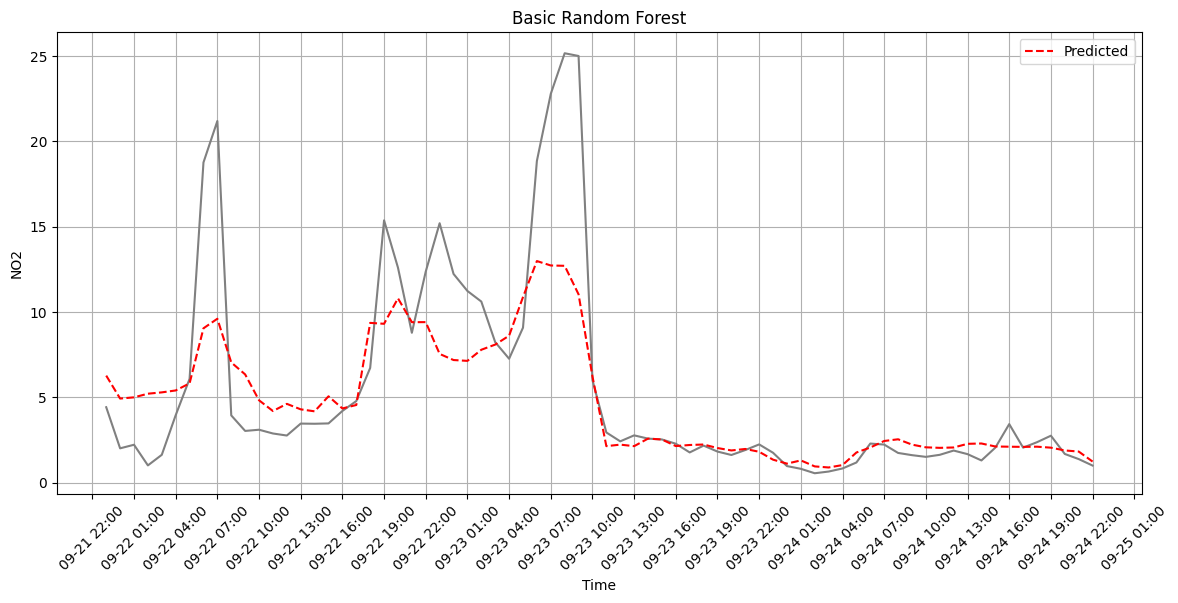

In [167]:
plot_real_vs_pred(test_scaled_df_rf[target_col],rf_updated_pred, "Basic Random Forest")

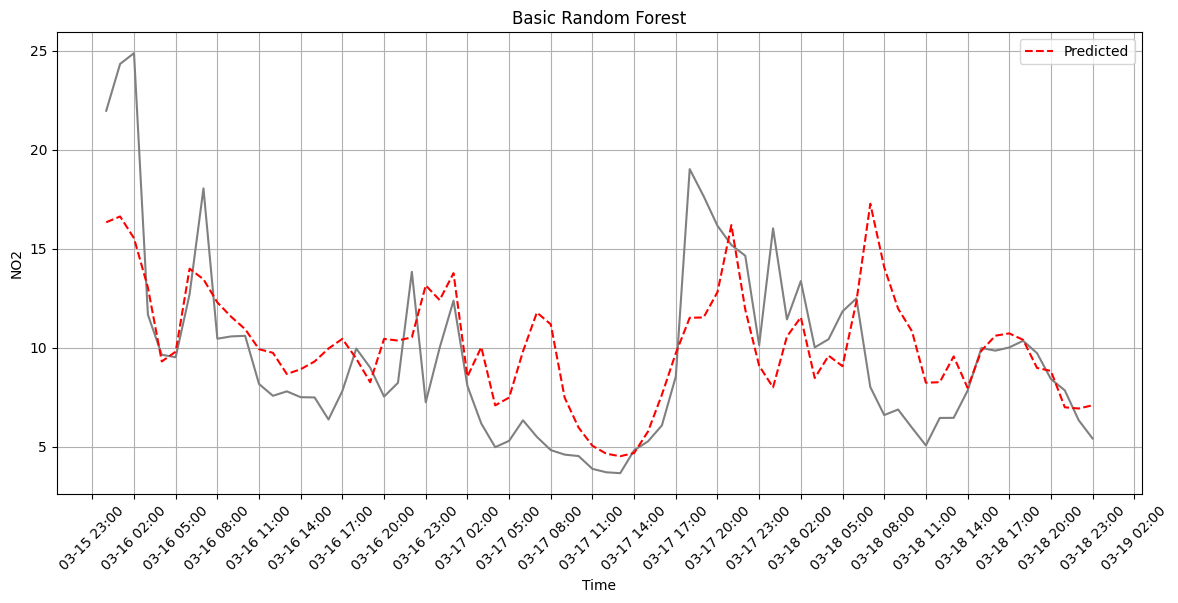

In [226]:
plot_real_vs_pred(test_scaled_df_rf_basic[target_col],rf_basic_pred, "Basic Random Forest")

In [98]:
from sklearn.metrics import r2_score

r2_test_basic2 = sqrt(mean_squared_error(y_test_adv1, adv_pred))
r2_test_basic2

0.09012881933960351

In [275]:
from sklearn.metrics import r2_score

r2_test_basic2 = r2_score(y_test_basic2, basic_pred2)
r2_test_basic2

0.5077980858294846

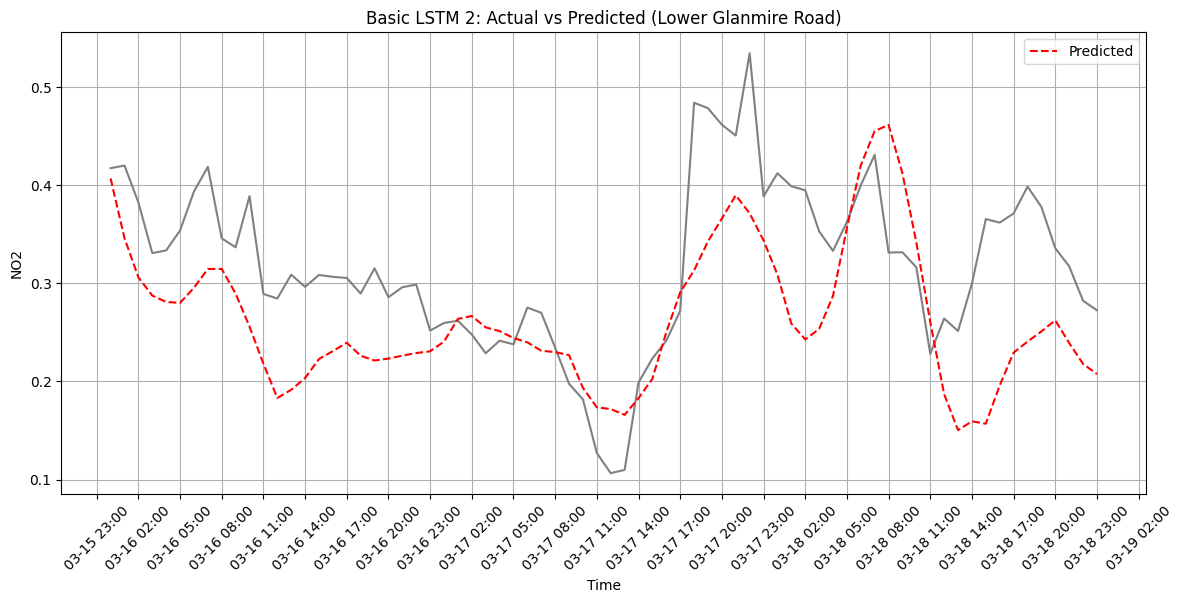

In [643]:
plot_real_vs_pred(y_test_basic2,basic_pred2, "Basic LSTM 2: Actual vs Predicted (Lower Glanmire Road)")


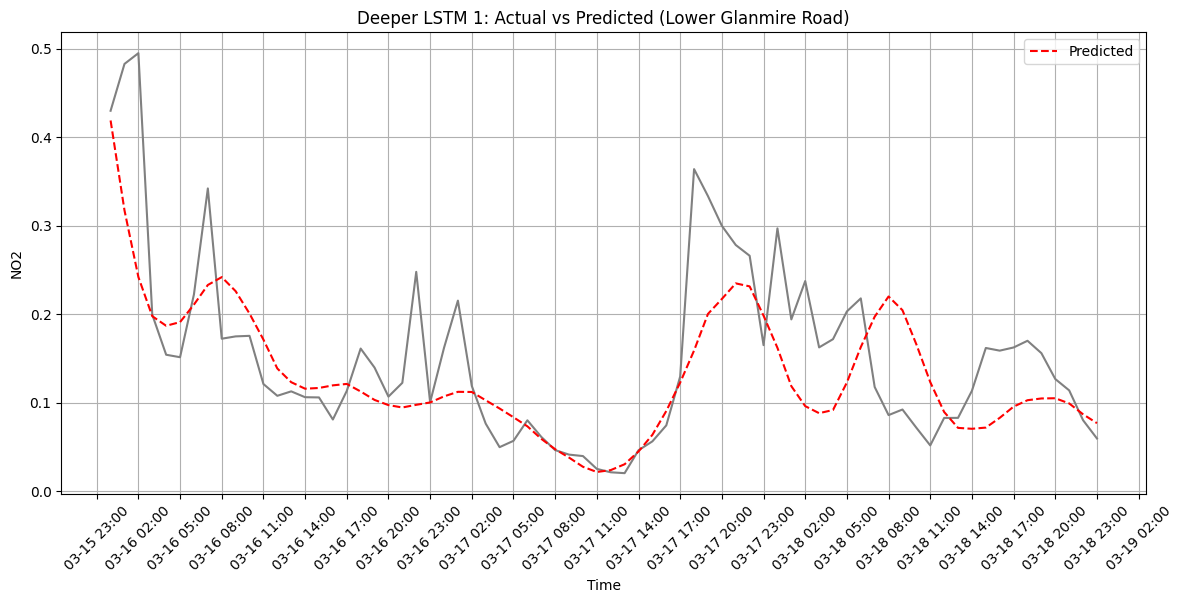

In [225]:
plot_real_vs_pred(y_test_adv1,adv_pred, "Deeper LSTM 1: Actual vs Predicted (Lower Glanmire Road)")


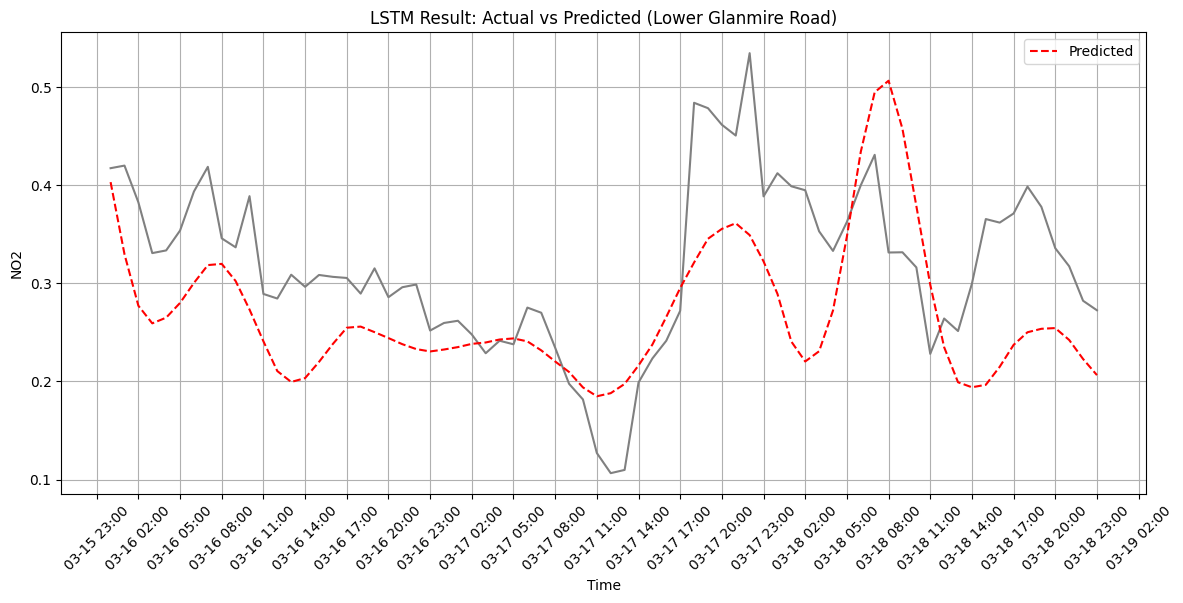

In [645]:
plot_real_vs_pred(y_test_adv1,adv_pred, "LSTM Result: Actual vs Predicted (Lower Glanmire Road)")


In [156]:
y_test_basic1[0:5], basic_pred2[0:5]

(array([0.45516745, 0.44067339, 0.36865322, 0.28312928, 0.28799064]),
 array([0.15586144, 0.17152378, 0.22202265, 0.27083275, 0.3161946 ],
       dtype=float32))

In [261]:
import numpy as np

# y_test_orig = scaler_y_adv1.inverse_transform(y_test_adv1.reshape(-1, 1))
# basic1_pred_orig = scaler_y_basic1.inverse_transform(basic_pred1.reshape(-1, 1))

# basic2_pred_orig = scaler_y_basic2.inverse_transform(basic_pred2.reshape(-1, 1))

# adv_pred1_orig = scaler_y_adv1.inverse_transform(adv_pred.reshape(-1, 1))


basic_rf_orig=rf_basic_pred.reshape(-1, 1)
updated_rf_orig=rf_updated_pred.reshape(-1, 1)
# adv_pred2_orig = scaler_y_adv2.inverse_transform(adv_pred2.reshape(-1, 1))


In [158]:
adv_pred1_orig[0:5], basic_rf_orig[0:5], updated_rf_orig[0:5], y_test_orig[0:5]

(array([[15.716376],
        [19.395403],
        [24.901701],
        [30.227692],
        [34.45556 ]], dtype=float32),
 array([[41.5104],
        [41.5867],
        [43.0544],
        [41.1514],
        [15.5123]]),
 array([[40.23967679],
        [35.59327693],
        [39.52043964],
        [39.1215749 ],
        [19.70679485]]),
 array([[50.56],
        [48.95],
        [40.95],
        [31.45],
        [31.99]]))

In [88]:
len(y_test_orig), len(updated_rf_orig)

NameError: name 'y_test_orig' is not defined

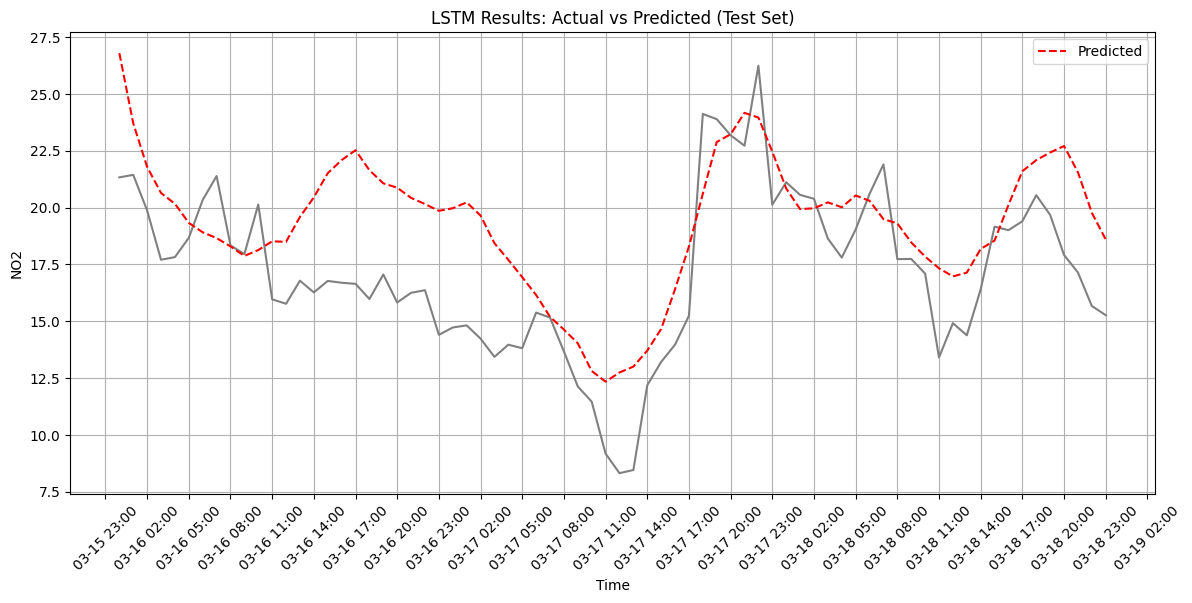

In [647]:
plot_real_vs_pred(y_test_orig,basic1_pred_orig, "LSTM Results: Actual vs Predicted (Test Set)")


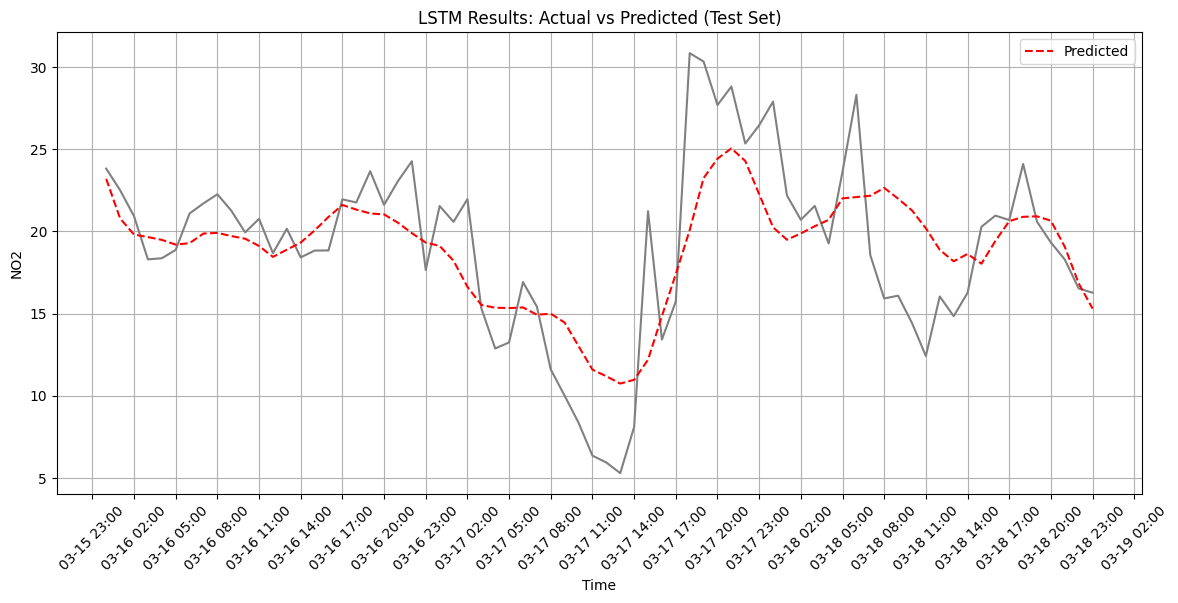

In [64]:
plot_real_vs_pred(y_test_orig,basic2_pred_orig, "LSTM Results: Actual vs Predicted (Test Set)")


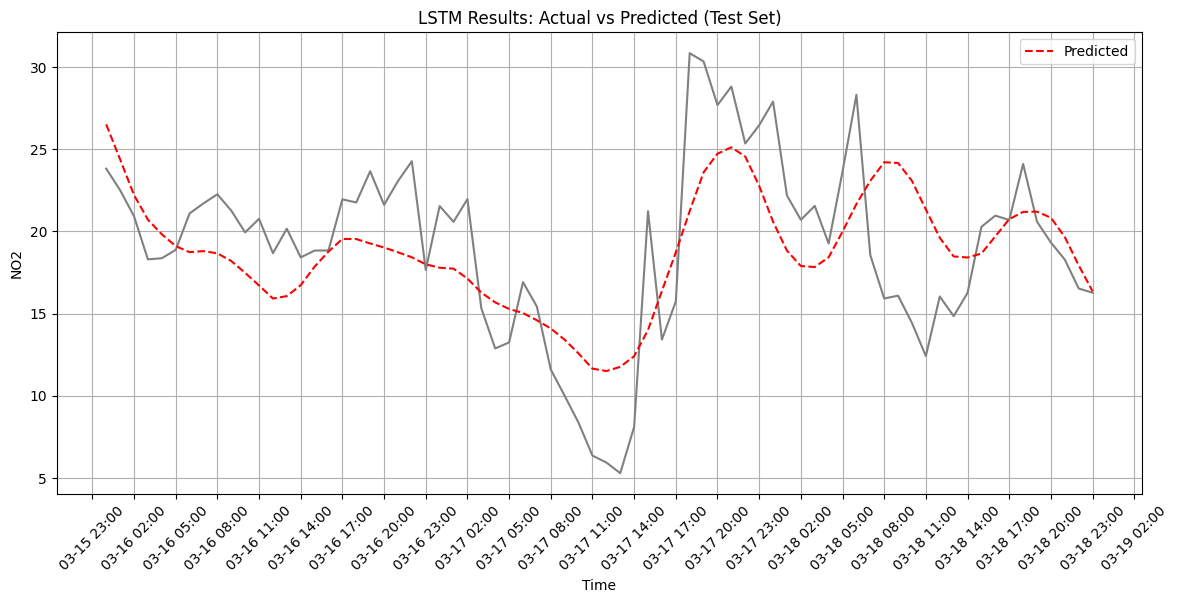

In [65]:
plot_real_vs_pred(y_test_orig,adv_pred1_orig, "LSTM Results: Actual vs Predicted (Test Set)")


In [89]:
y_train

array([[ 4.54633333],
       [ 7.494     ],
       [15.21866667],
       ...,
       [16.86866667],
       [20.56033333],
       [21.326     ]])

In [262]:
y_test=df1_test['NO2'].values

In [150]:
y_test

array([15.85333333, 15.16366667, 11.47033333, 10.096     , 10.81433333,
        9.816     , 16.05533333, 22.52133333, 22.83833333,  6.796     ,
        5.64033333,  5.24033333,  5.148     ,  5.86166667,  5.56931034,
        6.49548387,  6.85      ,  7.64533333, 10.71366667, 16.665     ,
       25.00733333, 25.89233333, 24.76033333, 24.68533333, 18.12933333,
       15.56733333, 12.63566667, 10.085     ,  9.52766667,  9.30833333,
       10.06566667, 15.713     , 16.70166667, 17.914     , 23.80966667,
       15.264     , 11.979     , 11.867     , 14.69433333, 18.37633333,
       17.708     , 18.268     , 18.135     , 18.019     , 18.02166667,
       12.83966667, 13.54133333, 13.57333333, 14.23833333, 12.22166667,
       12.43766667, 10.19633333,  8.29566667,  7.877     , 10.557     ,
       13.462     , 11.887     , 12.22166667, 11.82033333, 12.94433333,
       11.78733333, 14.52366667, 14.782     , 12.28633333, 11.84666667,
       10.658     , 12.114     , 13.88466667, 20.158     , 15.28

In [160]:
import math
rmse_test_adv1 = math.sqrt(mean_squared_error(y_test_orig, adv_pred1_orig))
mae_test_adv1 = mean_absolute_error(y_test_orig, adv_pred1_orig)

r2_test_adv1 = r2_score(y_test_orig, adv_pred1_orig)
rmse_test_adv1,mae_test_adv1,r2_test_adv1

(10.268073690641694, 8.0424335442649, 0.20144935962053867)

In [161]:
rmse_test_basic2 = math.sqrt(mean_squared_error(y_test_orig, basic2_pred_orig))
mae_test_basic2 = mean_absolute_error(y_test_orig, basic2_pred_orig)
r2_test_basic2 = r2_score(y_test_orig, basic2_pred_orig)
rmse_test_basic2,mae_test_basic2 ,r2_test_basic2

(9.523351338629137, 6.996953101158143, 0.3130832251237986)

In [162]:
rmse_test_basic1 = math.sqrt(mean_squared_error(y_test_orig, basic1_pred_orig))
mae_test_basic1 = mean_absolute_error(y_test_orig, basic1_pred_orig)
r2_test_basic1 = r2_score(y_test_orig, basic1_pred_orig)
rmse_test_basic1,mae_test_basic1 ,r2_test_basic1

(8.622007706614776, 6.347632847362094, 0.436957312971601)

In [163]:
import math
rmse_test_adv2 = math.sqrt(mean_squared_error(y_test_orig, adv_pred2_orig))
mae_test_adv2 = mean_absolute_error(y_test_orig, adv_pred2_orig)

r2_test_adv2 = r2_score(y_test_orig, adv_pred2_orig)
rmse_test_adv2,mae_test_adv2,r2_test_adv2

(11.311609930504494, 7.799567850960626, 0.030889386963693033)

In [263]:
rmse_test_basic_rf = math.sqrt(mean_squared_error(y_test, basic_rf_orig))
mae_test_basic_rf = mean_absolute_error(y_test, basic_rf_orig)


r2_test_basic_rf = r2_score(y_test, basic_rf_orig)
rmse_test_basic_rf,mae_test_basic_rf,r2_test_basic_rf

(3.2577632369841667, 2.727482138430138, 0.5756288821500197)

In [264]:
rmse_test_updated_rf = math.sqrt(mean_squared_error(y_test, updated_rf_orig))
mae_test_updated_rf = mean_absolute_error(y_test, updated_rf_orig)

r2_test_updated_rf = r2_score(y_test, updated_rf_orig)
rmse_test_updated_rf,mae_test_updated_rf ,r2_test_updated_rf

(3.3212526813808396, 2.794719717824436, 0.558926852656139)

In [337]:
y_test_orig_vals=[i[0] for i in y_test_orig]
# y_test_orig_vals

y_lstm_pred_orig_vals=[i[0] for i in adv_pred1_orig]
# y_lstm_pred_orig_vals
lst1=[]
lst2=[2]
for i in range(len(y_lstm_pred_orig_vals)):
    diff=y_test_orig_vals[i]-y_lstm_pred_orig_vals[i]
    if diff<-4:
      lst1.append(i)  
    elif diff>4:
      lst2.append(i)  

In [338]:
test_timestamp[lst1]

DatetimeIndex(['2024-05-19 16:00:00+01:00', '2024-05-20 04:00:00+01:00',
               '2024-05-20 05:00:00+01:00', '2024-05-20 16:00:00+01:00',
               '2024-05-20 17:00:00+01:00', '2024-05-20 18:00:00+01:00',
               '2024-05-20 19:00:00+01:00'],
              dtype='datetime64[ns, Europe/Dublin]', name='Timestamp', freq=None)

In [339]:
test_timestamp[lst2]

DatetimeIndex(['2024-05-18 02:00:00+01:00', '2024-05-18 09:00:00+01:00',
               '2024-05-18 10:00:00+01:00', '2024-05-18 15:00:00+01:00',
               '2024-05-18 21:00:00+01:00', '2024-05-19 18:00:00+01:00',
               '2024-05-19 19:00:00+01:00', '2024-05-19 21:00:00+01:00',
               '2024-05-19 22:00:00+01:00', '2024-05-19 23:00:00+01:00',
               '2024-05-20 00:00:00+01:00', '2024-05-20 01:00:00+01:00',
               '2024-05-20 11:00:00+01:00', '2024-05-20 20:00:00+01:00',
               '2024-05-20 21:00:00+01:00', '2024-05-20 22:00:00+01:00',
               '2024-05-20 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Dublin]', name='Timestamp', freq=None)

In [241]:
from numpy import ndim


ndim(y_lstm_pred_orig_vals)

1

In [ ]:
from sklearn.metrics import r2_score

r2_test_basic1 = r2_score(y_test_orig, basic1_pred_orig)
r2_test_basic1

0.5336023216351775

In [76]:
test_scaled_df[target_col].values

array([0.38471479, 0.35876474, 0.32755347, 0.27560062, 0.27691922,
       0.28695377, 0.33081041, 0.34292835, 0.35387932, 0.33425196,
       0.30800522, 0.32435586, 0.28302434, 0.31241594, 0.27793454,
       0.28614942, 0.28633403, 0.34776761, 0.34403597, 0.38166882,
       0.34113505, 0.36974867, 0.3936549 , 0.26275086, 0.33976371,
       0.32072971, 0.34803463, 0.2168101 , 0.16837865, 0.17567051,
       0.2482133 , 0.21874258, 0.1430813 , 0.11144809, 0.07902371,
       0.03944592, 0.03119808, 0.01838129, 0.07398006, 0.3335531 ,
       0.17910546, 0.22498615, 0.52364909, 0.51358817, 0.46120678,
       0.48353728, 0.4149371 , 0.43691157, 0.46534059, 0.35242886,
       0.32316935, 0.33989812, 0.29468077, 0.38112819, 0.47356207,
       0.28065745, 0.22852   , 0.2319154 , 0.19901632, 0.15926053,
       0.23093304, 0.20726417, 0.23529761, 0.31476964, 0.32821277,
       0.32289222, 0.3903584 , 0.32091432, 0.29584773, 0.27536987,
       0.24053245, 0.23550199])

In [77]:
scaler_y_rf.inverse_transform(test_scaled_df[target_col].values.reshape(-1, 1)).ravel()

array([23.812     , 22.5       , 20.922     , 18.29533333, 18.362     ,
       18.86933333, 21.08666667, 21.69933333, 22.253     , 21.26066667,
       19.93366667, 20.76033333, 18.67066667, 20.15666667, 18.41333333,
       18.82866667, 18.838     , 21.944     , 21.75533333, 23.658     ,
       21.60866667, 23.05533333, 24.264     , 17.64566667, 21.53933333,
       20.577     , 21.9575    , 15.32296296, 12.87433333, 13.243     ,
       16.91066667, 15.42066667, 11.59533333,  9.996     ,  8.35666667,
        6.35566667,  5.93866667,  5.29066667,  8.10166667, 21.22533333,
       13.41666667, 15.73633333, 30.83633333, 30.32766667, 27.67933333,
       28.80833333, 25.34      , 26.451     , 27.88833333, 22.17966667,
       20.70034483, 21.54612903, 19.26      , 23.63066667, 28.304     ,
       18.551     , 15.915     , 16.08666667, 14.42333333, 12.41333333,
       16.037     , 14.84033333, 16.25766667, 20.27566667, 20.95533333,
       20.68633333, 24.09733333, 20.58633333, 19.319     , 18.28

In [171]:
test_scaled_df[feature_cols_updated_rf]

,temp,rhum,msl,wdsp,vis,clht,clamt,school_term,wddir_sin,wddir_cos,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_sin,hour_cos,PCA_car1,PCA_hgv1
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-16 00:00:00+00:00,0.320,0.736842,0.703753,0.161290,0.284692,0.477912,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.500000,1.000000,0.122711,0.057977
2024-03-16 01:00:00+00:00,0.320,0.929825,0.706434,0.129032,0.284692,0.236948,0.857143,1.0,0.933013,0.250000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.629410,0.982963,0.087180,0.042423
2024-03-16 02:00:00+00:00,0.336,0.982456,0.706434,0.129032,0.141631,0.236948,0.857143,1.0,0.586824,0.007596,...,0.0,0.0,0.0,0.0,1.0,0.0,0.750000,0.933013,0.065245,0.046818
2024-03-16 03:00:00+00:00,0.340,0.947368,0.697051,0.161290,0.141631,0.152610,0.857143,1.0,0.750000,0.066987,...,0.0,0.0,0.0,0.0,1.0,0.0,0.853553,0.853553,0.063890,0.044108
2024-03-16 04:00:00+00:00,0.324,0.947368,0.693029,0.290323,0.098712,0.068273,0.857143,1.0,0.821394,0.116978,...,0.0,0.0,0.0,0.0,1.0,0.0,0.933013,0.750000,0.047123,0.081722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18 19:00:00+00:00,0.460,0.982456,0.552279,0.612903,0.041488,0.008032,0.857143,1.0,0.328990,0.030154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.017037,0.629410,0.402506,0.151674
2024-03-18 20:00:00+00:00,0.472,0.982456,0.553619,0.612903,0.098712,0.008032,0.857143,1.0,0.413176,0.007596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.066987,0.750000,0.292888,0.091149
2024-03-18 21:00:00+00:00,0.468,0.982456,0.552279,0.612903,0.127325,0.008032,0.857143,1.0,0.250000,0.066987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.146447,0.853553,0.195014,0.069222


In [83]:
scaler_y_rf.inverse_transform(y_pred_scaled_rf.reshape(-1, 1)).ravel()

array([21.56671532, 22.39410106, 21.59994173, 20.66345186, 15.92055745,
       15.32116061, 18.05855735, 19.06539064, 20.71235385, 20.73627914,
       20.51742765, 20.32747119, 20.63132428, 19.11469151, 19.1408135 ,
       19.3518195 , 21.4833363 , 21.85299137, 22.5584617 , 23.21875542,
       20.90288513, 23.62365394, 23.29066699, 23.61199668, 22.82939948,
       20.16367005, 18.73431729, 16.56807298, 14.74885632, 14.98128893,
       17.14914881, 17.05344434, 17.92226218, 15.66384962, 14.2261882 ,
       12.8500029 , 13.08048832, 13.22699192, 14.14142226, 14.6711472 ,
       18.42814902, 19.66877367, 24.78453557, 23.23162492, 23.36025647,
       27.87315637, 20.61187645, 20.77069478, 22.73940109, 22.13374138,
       21.60021806, 19.07320439, 17.27721072, 16.17408727, 17.23914   ,
       17.67966373, 16.1154105 , 20.81337874, 18.53356885, 15.92491122,
       15.98374037, 17.66767042, 16.45840055, 18.63723496, 22.11838796,
       21.84527375, 22.41048118, 21.74080479, 20.17864006, 19.03

In [84]:
scaler_y.inverse_transform(y_pred_scaled_rf.reshape(-1, 1)).ravel()

array([21.56671532, 22.39410106, 21.59994173, 20.66345186, 15.92055745,
       15.32116061, 18.05855735, 19.06539064, 20.71235385, 20.73627914,
       20.51742765, 20.32747119, 20.63132428, 19.11469151, 19.1408135 ,
       19.3518195 , 21.4833363 , 21.85299137, 22.5584617 , 23.21875542,
       20.90288513, 23.62365394, 23.29066699, 23.61199668, 22.82939948,
       20.16367005, 18.73431729, 16.56807298, 14.74885632, 14.98128893,
       17.14914881, 17.05344434, 17.92226218, 15.66384962, 14.2261882 ,
       12.8500029 , 13.08048832, 13.22699192, 14.14142226, 14.6711472 ,
       18.42814902, 19.66877367, 24.78453557, 23.23162492, 23.36025647,
       27.87315637, 20.61187645, 20.77069478, 22.73940109, 22.13374138,
       21.60021806, 19.07320439, 17.27721072, 16.17408727, 17.23914   ,
       17.67966373, 16.1154105 , 20.81337874, 18.53356885, 15.92491122,
       15.98374037, 17.66767042, 16.45840055, 18.63723496, 22.11838796,
       21.84527375, 22.41048118, 21.74080479, 20.17864006, 19.03

In [172]:
feature_cols_updated_rf

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'cp24_meanNO2',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'hour_sin',
 'hour_cos',
 'PCA_car1',
 'PCA_hgv1']

In [150]:
len(scaler_y_rf.inverse_transform(y_pred_scaled_rf.reshape(-1, 1)))
y_pred = scaler_y_rf.inverse_transform(y_pred_scaled_rf.reshape(-1, 1)).ravel()
len(y_pred)

72

In [155]:
feature_cols

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'school_term',
 'wddir_sin',
 'wddir_cos',
 'day_of_year',
 'rain_log1p',
 'car_r1',
 'hgv_r1',
 'car_r2',
 'hgv_r2',
 'car_r3',
 'hgv_r3',
 'car_r4',
 'hgv_r4',
 'cp24_meanNO2',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'hour_sin',
 'hour_cos']

In [180]:
test_scaled_df.columns

Index(['temp', 'rhum', 'msl', 'wdsp', 'vis', 'clht', 'clamt', 'school_term',
       'wddir_sin', 'wddir_cos', 'day_of_year', 'rain_log1p', 'cp24_meanNO2',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'hour_sin', 'hour_cos', 'PCA_car1',
       'PCA_hgv1', 'NO2'],
      dtype='object')

In [174]:
y_pred_scaled_rf = best_model.predict(test_scaled_df[feature_cols_updated_rf])

# Inverse transform predictions and actual values
y_pred = scaler_y_rf.inverse_transform(y_pred_scaled_rf.reshape(-1, 1)).ravel()
y_true = scaler_y_rf.inverse_transform(test_scaled_df[target_col].values.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

mae,rmse,r2

c:\Python\Python311\Lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


(2.687839242285241, 3.641656011252866, 0.5505351156060393)

In [181]:
feature_cols_rf_basic

['temp',
 'rhum',
 'msl',
 'wdsp',
 'vis',
 'clht',
 'clamt',
 'day_of_year',
 'rain_log1p',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_7',
 'wddir',
 'hour']

In [182]:
y_pred_scaled_rf_basic = best_model_rf_basic.predict(test_scaled_df[feature_cols_rf_basic])

# Inverse transform predictions and actual values
y_pred = scaler_y_rf.inverse_transform(y_pred_scaled_rf_basic.reshape(-1, 1)).ravel()
y_true = scaler_y_rf.inverse_transform(test_scaled_df[target_col].values.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mae,rmse,r2


KeyError: "['wddir', 'hour'] not in index"

In [137]:
mae_l = mean_absolute_error(y_test_orig, basic2_pred_orig)
rmse_l = sqrt(mean_squared_error(y_test_orig, basic2_pred_orig))
r2_l = r2_score(y_test_orig, basic2_pred_orig)

In [138]:
mae_l, rmse_l,r2_l


(2.7266234836451892, 3.5775306559165934, 0.5662248641340832)

In [139]:
mae, rmse,r2

(3.140536716541738, 4.095684067761189, 0.5905701476578153)

In [161]:
y_test_orig[15:]

array([[ 3.45],
       [ 3.47],
       [ 4.2 ],
       [ 4.78],
       [ 6.72],
       [15.37],
       [12.6 ],
       [ 8.78],
       [12.37],
       [15.2 ],
       [12.23],
       [11.23],
       [10.61],
       [ 8.23],
       [ 7.26],
       [ 9.08],
       [18.85],
       [22.78],
       [25.16],
       [25.  ],
       [ 6.01],
       [ 2.94],
       [ 2.42],
       [ 2.77],
       [ 2.58],
       [ 2.53],
       [ 2.28],
       [ 1.77],
       [ 2.17],
       [ 1.82],
       [ 1.62],
       [ 1.91],
       [ 2.24],
       [ 1.75],
       [ 0.97],
       [ 0.81],
       [ 0.55],
       [ 0.65],
       [ 0.83],
       [ 1.18],
       [ 2.29],
       [ 2.23],
       [ 1.74],
       [ 1.61],
       [ 1.51],
       [ 1.63],
       [ 1.88],
       [ 1.67],
       [ 1.3 ],
       [ 2.05],
       [ 3.43],
       [ 2.05],
       [ 2.37],
       [ 2.75],
       [ 1.68],
       [ 1.38],
       [ 1.  ]])

In [162]:
basic2_pred_orig[15:]


array([[ 7.6395187 ],
       [ 7.823667  ],
       [ 7.9802985 ],
       [ 7.776844  ],
       [ 7.885516  ],
       [ 8.129328  ],
       [ 8.774634  ],
       [ 9.065833  ],
       [ 8.936216  ],
       [ 8.703579  ],
       [ 7.427692  ],
       [ 6.937147  ],
       [ 6.9755898 ],
       [ 7.3684216 ],
       [ 8.002583  ],
       [ 8.865537  ],
       [10.153517  ],
       [10.602462  ],
       [10.638832  ],
       [10.043959  ],
       [ 9.334407  ],
       [ 8.797132  ],
       [ 6.839853  ],
       [ 5.731036  ],
       [ 4.8033566 ],
       [ 3.9480631 ],
       [ 3.3302438 ],
       [ 2.781948  ],
       [ 2.5900078 ],
       [ 2.2258465 ],
       [ 1.5137615 ],
       [ 1.093177  ],
       [ 1.2663966 ],
       [ 1.4714267 ],
       [ 0.7079624 ],
       [ 0.28018874],
       [ 0.29501942],
       [ 0.28621426],
       [ 0.31349045],
       [ 0.57172436],
       [ 0.98227304],
       [ 1.3099731 ],
       [ 1.6417749 ],
       [ 1.961237  ],
       [ 2.0967836 ],
       [ 2

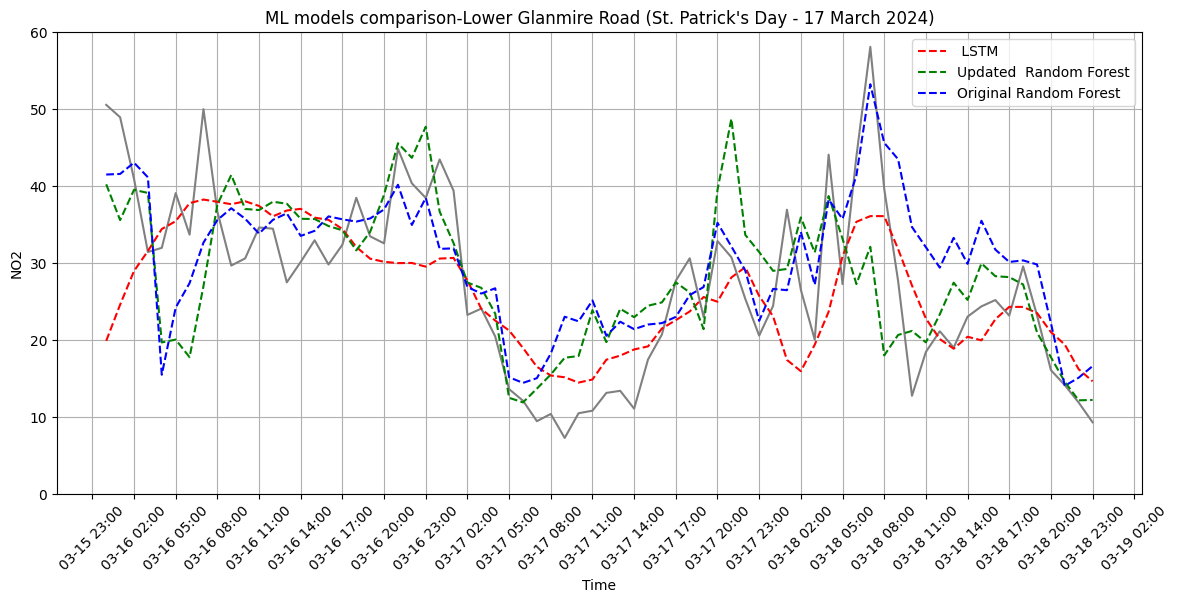

In [167]:
def model_comparison(y_true,y_pred1, y_pred2, y_pred3,title):
    plt.figure(figsize=(14,6))
    plt.plot(test_timestamp,y_true, color='grey')
    plt.plot(test_timestamp,y_pred1,'r--', label=' LSTM')
    plt.plot(test_timestamp,y_pred2,'g--', label='Updated  Random Forest')
    plt.plot(test_timestamp,y_pred3,'b--', label='Original Random Forest')

    plt.xlabel("Time")
    plt.ylabel("NO2")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 60)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

    plt.xticks(rotation=45)
    plt.show()


model_comparison(y_test_orig, basic1_pred_orig,updated_rf_orig,basic_rf_orig,'ML models comparison-Lower Glanmire Road (St. Patrick\'s Day - 17 March 2024)')
# Open Streets Event Day - 19 May 2024


In [853]:
(updated_rf_orig-y_test_orig)>0

array([[ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [

In [851]:
y_test_orig

array([[16.395     ],
       [16.13068966],
       [16.13321429],
       [14.82259259],
       [12.56076923],
       [13.42826087],
       [16.48653846],
       [22.32066667],
       [23.13678571],
       [ 9.33275862],
       [ 8.69785714],
       [ 7.30633333],
       [ 8.12166667],
       [ 8.02233333],
       [ 7.69866667],
       [ 9.18033333],
       [ 8.63733333],
       [11.375     ],
       [12.33766667],
       [21.75533333],
       [26.18166667],
       [23.57833333],
       [23.74666667],
       [20.86346154],
       [21.81484848],
       [18.70966667],
       [17.23166667],
       [14.32896552],
       [14.27586207],
       [13.53714286],
       [15.24333333],
       [17.8325    ],
       [17.2444    ],
       [18.75666667],
       [22.1864    ],
       [13.87896552],
       [12.50333333],
       [12.564     ],
       [15.075     ],
       [18.71166667],
       [17.07966667],
       [15.708     ],
       [14.495     ],
       [13.3137931 ],
       [11.86066667],
       [10

In [86]:
y_true

array([23.812     , 22.5       , 20.922     , 18.29533333, 18.362     ,
       18.86933333, 21.08666667, 21.69933333, 22.253     , 21.26066667,
       19.93366667, 20.76033333, 18.67066667, 20.15666667, 18.41333333,
       18.82866667, 18.838     , 21.944     , 21.75533333, 23.658     ,
       21.60866667, 23.05533333, 24.264     , 17.64566667, 21.53933333,
       20.577     , 21.9575    , 15.32296296, 12.87433333, 13.243     ,
       16.91066667, 15.42066667, 11.59533333,  9.996     ,  8.35666667,
        6.35566667,  5.93866667,  5.29066667,  8.10166667, 21.22533333,
       13.41666667, 15.73633333, 30.83633333, 30.32766667, 27.67933333,
       28.80833333, 25.34      , 26.451     , 27.88833333, 22.17966667,
       20.70034483, 21.54612903, 19.26      , 23.63066667, 28.304     ,
       18.551     , 15.915     , 16.08666667, 14.42333333, 12.41333333,
       16.037     , 14.84033333, 16.25766667, 20.27566667, 20.95533333,
       20.68633333, 24.09733333, 20.58633333, 19.319     , 18.28

In [68]:
test_timestamp[550:600]

DatetimeIndex(['2024-05-18 17:00:00+01:00', '2024-05-18 18:00:00+01:00',
               '2024-05-18 19:00:00+01:00', '2024-05-18 20:00:00+01:00',
               '2024-05-18 21:00:00+01:00', '2024-05-18 22:00:00+01:00',
               '2024-05-18 23:00:00+01:00', '2024-05-19 00:00:00+01:00',
               '2024-05-19 01:00:00+01:00', '2024-05-19 02:00:00+01:00',
               '2024-05-19 03:00:00+01:00', '2024-05-19 04:00:00+01:00',
               '2024-05-19 05:00:00+01:00', '2024-05-19 06:00:00+01:00',
               '2024-05-19 07:00:00+01:00', '2024-05-19 08:00:00+01:00',
               '2024-05-19 09:00:00+01:00', '2024-05-19 10:00:00+01:00',
               '2024-05-19 11:00:00+01:00', '2024-05-19 12:00:00+01:00',
               '2024-05-19 13:00:00+01:00', '2024-05-19 14:00:00+01:00',
               '2024-05-19 15:00:00+01:00', '2024-05-19 16:00:00+01:00',
               '2024-05-19 17:00:00+01:00', '2024-05-19 18:00:00+01:00',
               '2024-05-19 19:00:00+01:00', '2024-0

In [ ]:

# -------------------------------
# Step 2: Function to preprocess per station
# -------------------------------
def preprocess_and_train(station_df, target_col='NO2', window_size=72, pca_cols=['car_r1','car_r2','car_r3','car_r4', 'hgv_r1','hgv_r2','hgv_r3','hgv_r4'], n_pca_components=1):
    # 1. Split into train/val/test
    n = len(station_df)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)

    train_df = station_df.iloc[:train_end]
    val_df = station_df.iloc[train_end:val_end]
    test_df = station_df.iloc[val_end:]

    # 2. PCA on selected columns
    pca = PCA(n_components=n_pca_components)
    pca.fit(train_df[pca_cols])

    def apply_pca(df):
        pca_transformed = pca.transform(df[pca_cols])
        pca_df = pd.DataFrame(pca_transformed, index=df.index, columns=[f'PCA_{i+1}' for i in range(n_pca_components)])
        df_copy = df.drop(columns=pca_cols).copy()
        return pd.concat([df_copy, pca_df], axis=1)

    train_df = apply_pca(train_df)
    val_df = apply_pca(val_df)
    test_df = apply_pca(test_df)

    # 3. Scale features
    feature_cols = [c for c in train_df.columns if c != target_col and c != 'station']
    scaler = MinMaxScaler()
    scaler.fit(train_df[feature_cols])

    train_scaled = scaler.transform(train_df[feature_cols])
    val_scaled = scaler.transform(val_df[feature_cols])
    test_scaled = scaler.transform(test_df[feature_cols])

    # Create scaled DataFrames (keep target unscaled for now)
    train_scaled_df = pd.DataFrame(train_scaled, index=train_df.index, columns=feature_cols)
    val_scaled_df = pd.DataFrame(val_scaled, index=val_df.index, columns=feature_cols)
    test_scaled_df = pd.DataFrame(test_scaled, index=test_df.index, columns=feature_cols)

    # Add target (scaled)
    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_df[[target_col]])
    val_target_scaled = target_scaler.transform(val_df[[target_col]])
    test_target_scaled = target_scaler.transform(test_df[[target_col]])

    train_scaled_df[target_col] = train_target_scaled
    val_scaled_df[target_col] = val_target_scaled
    test_scaled_df[target_col] = test_target_scaled

    # 4. Create sequences
    def make_sequences(data_df):
        X, y = [], []
        for i in range(window_size, len(data_df)):
            X.append(data_df.iloc[i-window_size:i][feature_cols].values)
            y.append(data_df.iloc[i][target_col])
        return np.array(X), np.array(y)

    X_train, y_train = make_sequences(train_scaled_df)
    X_val, y_val = make_sequences(val_scaled_df)
    X_test, y_test = make_sequences(test_scaled_df)

    # 5. Build LSTM
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # 6. Train
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=30,
              batch_size=32,
              callbacks=[early_stop],
              verbose=1)

    # 7. Evaluate
    y_pred_test = model.predict(X_test).flatten()
    rmse_test = math.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"Station: {station_df['station'].iloc[0]}, Test RMSE: {rmse_test:.4f}")

    return rmse_test

# -------------------------------
# Step 3: Run for all stations
# -------------------------------
station_names = df['station'].unique()
results = {}

for station in station_names:
    station_df = df[df['station'] == station].copy()
    rmse = preprocess_and_train(station_df)
    results[station] = rmse

print("\nFinal RMSE per station:", results)


In [265]:
y_test=df1_test['NO2']
df1_test['NO2_pred']=rf_basic_pred

pred=df1_test['NO2_pred']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1370812\2633817859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test['NO2_pred']=rf_basic_pred


In [266]:
y_test

Timestamp
2023-09-22 00:00:00+01:00    15.853333
2023-09-22 01:00:00+01:00    15.163667
2023-09-22 02:00:00+01:00    11.470333
2023-09-22 03:00:00+01:00    10.096000
2023-09-22 04:00:00+01:00    10.814333
                               ...    
2023-09-24 19:00:00+01:00    13.884667
2023-09-24 20:00:00+01:00    20.158000
2023-09-24 21:00:00+01:00    15.286667
2023-09-24 22:00:00+01:00    13.590667
2023-09-24 23:00:00+01:00     9.642000
Name: NO2, Length: 72, dtype: float64

In [267]:
pred

Timestamp
2023-09-22 00:00:00+01:00    11.542429
2023-09-22 01:00:00+01:00    11.418157
2023-09-22 02:00:00+01:00    10.691278
2023-09-22 03:00:00+01:00     9.981904
2023-09-22 04:00:00+01:00     9.173623
                               ...    
2023-09-24 19:00:00+01:00    15.329777
2023-09-24 20:00:00+01:00    16.669045
2023-09-24 21:00:00+01:00    15.867436
2023-09-24 22:00:00+01:00    13.431617
2023-09-24 23:00:00+01:00    12.969566
Name: NO2_pred, Length: 72, dtype: float64

In [268]:
import numpy as np, pandas as pd, statsmodels.api as sm

# y_true, y_pred are pandas Series indexed by timestamp
resid = y_test - pred

# mask for 2024-03-17 between 07:00 and 17:30 (inclusive of 17:00, exclusive of 17:30)
mask = (resid.index.date == pd.to_datetime("2023-09-23").date()) & \
       (resid.index.time >= pd.to_datetime("12:00").time()) & \
       (resid.index.time <= pd.to_datetime("19:00").time())

r_event = resid.loc[mask].values
X = np.ones(len(r_event))  # regression on a constant tests mean != 0
ols = sm.OLS(r_event, X).fit(cov_type="HAC", cov_kwds={"maxlags":4})  # 4~6 lags for hourly data

mean_diff = ols.params[0]
pval = ols.pvalues[0]
print(f"Mean residual (event window): {mean_diff:.2f} µg/m³,  p={pval:.4f}")


Mean residual (event window): 0.51 µg/m³,  p=0.6070


In [269]:
y_test.loc[mask].values

array([11.979     , 11.867     , 14.69433333, 18.37633333, 17.708     ,
       18.268     , 18.135     , 18.019     ])

In [270]:
(r_event/y_test.loc[mask].values)*100

array([-11.57465233, -17.89967667, -13.93556368,   7.04905153,
         3.7657506 ,  14.68833125,  15.63713464,  11.76843528])

In [271]:
pred.loc[mask].values

array([13.3655276 , 13.99115463, 16.74207151, 17.08097612, 17.04116088,
       15.58473565, 15.29920563, 15.89844565])

In [273]:
spd_sps=pd.DataFrame({
    'Hour of the Day': [12,13,14,15,16,17,18,19],
   'Actual NO2' : y_test.loc[mask].values,
   'Expected NO2': pred.loc[mask].values,
   'Percentage change': (r_event/y_test.loc[mask].values)*100
})

spd_sps

,Hour of the Day,Actual NO2,Expected NO2,Percentage change
0,12,11.979000,13.365528,-11.574652
1,13,11.867000,13.991155,-17.899677
2,14,14.694333,16.742072,-13.935564
3,15,18.376333,17.080976,7.049052
4,16,17.708000,17.041161,3.765751
5,17,18.268000,15.584736,14.688331
6,18,18.135000,15.299206,15.637135
7,19,18.019000,15.898446,11.768435
